In [76]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import sys
from ipywidgets import interactive, FloatSlider, interact, fixed
from divtel import *
from adjustText import adjust_text

import copy
import astropy.units as u
from astropy.coordinates import SkyCoord

from astroplan.plots import plot_sky
from astroplan import FixedTarget
#from . import utils
#from .const import COLORS
#from . import pointing

from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

import healpy as hp
import tqdm

#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOAD CTA CONFIG

In [5]:
cta = CTA_Info('south')

Observer         :  CTA South
Location         :  Paranal , (1946.635798, -5467.63394562, -2642.49852123) km
Observation time :  2025-02-21T22:55:47.037


In [6]:
array_MST = LoadConfig("/Users/macbook/divtel/Paranal_Only_MST.txt", frame=cta)

In [7]:

array_SST = LoadConfig("/Users/macbook/divtel/Paranal_Only_SST.txt", frame=cta)

In [8]:
array_MST.table.units = "deg"
array_MST.table
array_SST.table.units ="deg"

In [9]:
def compute_center_of_gravity(group):
    x, y, z = group['x'], group['y'], group['z']
    cog_x = round(np.mean(x),2)
    cog_y = round(np.mean(y),2)
    cog_z = round(np.mean(z),2)
    return cog_x, cog_y, cog_z

# Function to create new telescope list with center of gravity
def create_new_group_list(tel_group):
    new_telescopes = []
    for group in tel_group.groups:
        print(tel_group.groups)
        print (group['focal'][0],round(group['radius'][0],2))
        #id_ = group["id"][0]
        cog = compute_center_of_gravity(group)
        focal, fov = group['focal'][0], round(group['radius'][0],2)  # Assuming same within a group
        new_telescopes.append([*cog, focal, fov])
    return new_telescopes


In [10]:
array_MST.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.0,0.0,24.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,22.65
2,0.0,151.0,25.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,152.67
3,0.0,-151.0,31.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,152.68
4,150.0,75.0,21.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,188.09
5,150.0,-75.0,26.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,187.98
6,150.0,240.0,24.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,295.50
7,150.0,-240.0,30.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,295.49
8,313.0,0.0,19.0,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,335.47


In [11]:
array_SST.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,199.0,0.0,16.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,200.19
2,-230.0,0.0,22.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,229.36
3,-249.0,-325.0,40.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,409.12
4,-249.0,325.0,17.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,409.16
5,-249.0,-577.0,54.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,628.62
6,-249.0,577.0,8.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,628.51
7,-220.0,-797.0,68.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,827.51
8,-220.0,797.0,10.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,826.84


## Choosing the different configurations

In [12]:
sub_groups_MST={'1':[3,4,7], 
            '2': [1,9,12,14],
            '3': [10,11,13], 
             '4': [2,6,8,5]}
sub_groups_SST = {'1':[24,12,30,42,8,18], 
             '2':[44,32,34],
              '3':[43,33,35],
              '4':[23,41,29,11,7,17],
              '5':[37,39,45],
              '6':[38,40,46],
              '7':[1,2,9,10],
              '8':[16,26,28],
              '9':[15,25,27],
              '10':[13,14,36],
              '11':[5,19,21],
              '12':[6,20,22],
              '13':[3,4,31]}



In [13]:
tel_group, labels, number_of_telescopes_subarray_1 =array_MST.group_by(sub_groups_MST)

In [14]:
tel_group_SST, labels_SST, number_of_telescopes_config_SST =array_SST.group_by(sub_groups_SST)

In [15]:
new_telescopes = create_new_group_list(tel_group)

<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85


In [16]:
new_telescopes_SST = create_new_group_list(tel_group_SST)

<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45


In [17]:
for telescope in new_telescopes:
    print(telescope)

[100.0, -105.33, 27.33, 16.0, 3.85]
[-153.25, 81.75, 27.38, 16.0, 3.85]
[-204.33, -109.0, 33.83, 16.0, 3.85]
[153.25, 79.0, 23.5, 16.0, 3.85]


In [18]:
for telescope in new_telescopes_SST:
    print(telescope)

[0.0, 816.83, 21.83, 5.6, 4.45]
[-840.0, 404.67, 16.75, 5.6, 4.45]
[-840.0, -404.67, 55.92, 5.6, 4.45]
[0.0, -816.83, 65.42, 5.6, 4.45]
[839.67, -404.67, 17.75, 5.6, 4.45]
[839.67, 404.67, 10.08, 5.6, 4.45]
[-7.75, 0.0, 22.5, 5.6, 4.45]
[415.67, 402.0, 12.42, 5.6, 4.45]
[415.67, -402.0, 27.92, 5.6, 4.45]
[429.33, 0.0, 16.08, 5.6, 4.45]
[-415.67, -402.0, 48.25, 5.6, 4.45]
[-415.67, 402.0, 15.58, 5.6, 4.45]
[-429.67, 0.0, 29.42, 5.6, 4.45]


In [19]:
# Define the file path where you want to save the output
output_file_path = './best_configuration_MST.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./best_configuration_MST.txt


In [20]:
# Define the file path where you want to save the output
output_file_path = './best_configuration_SST.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes_SST):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./best_configuration_SST.txt


In [21]:
config_MST = LoadConfig("/Users/macbook/divtel/best_configuration_MST.txt", frame=cta)
config_SST = LoadConfig("/Users/macbook/divtel/best_configuration_SST.txt", frame=cta)
full_array_config_SST = LoadConfig("/Users/macbook/divtel/best_configuration_SST.txt", frame=cta)

In [22]:
config_MST.table.units= "deg"

In [23]:
config_MST.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,100.0,-105.33,27.33,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,156.04
2,-153.25,81.75,27.38,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,158.82
3,-204.33,-109.0,33.83,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,202.35
4,153.25,79.0,23.5,0.000,0.000,90.000,16.000,3.850,46.707,1.000,-0.000,0.000,201.79


In [24]:
config_SST.table.units = "deg"

In [25]:
config_SST.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.0,816.83,21.83,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,816.85
2,-840.0,404.67,16.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,931.85
3,-840.0,-404.67,55.92,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.21
4,0.0,-816.83,65.42,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,817.70
5,839.67,-404.67,17.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.76
6,839.67,404.67,10.08,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.87
7,-7.75,0.0,22.5,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,8.77
8,415.67,402.0,12.42,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,578.95


In [26]:
div_stop=[]

div_stop=np.linspace(0,0.03, 10)


In [27]:
FoV_array_MST=[]#This will be the one without saturation
multiplicity_array_MST=[] #This will be the one without saturation

for div in div_stop:
    config_MST.divergent_pointing(div, az=0,alt=70)    
    FoV_array_MST=config_MST.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0]
    multiplicity_array_MST=config_MST.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1]



4it [00:00,  6.44it/s]
4it [00:00,  7.45it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.19it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.68it/s]
4it [00:00,  7.56it/s]
4it [00:00,  7.53it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.49it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.46it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.59it/s]
4it [00:00,  7.29it/s]
4it [00:00,  7.54it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.48it/s]


In [28]:
FoV_array_SST=[]#This will be the one without saturation
multiplicity_array_SST=[] #This will be the one without saturation

for div in div_stop:
    config_SST.divergent_pointing(div, az=0,alt=70)    
    FoV_array_SST=config_SST.hFoV(subarray_mult=number_of_telescopes_config_SST)[0]
    multiplicity_array_SST=config_SST.hFoV(subarray_mult=number_of_telescopes_config_SST)[1]


13it [00:01,  7.26it/s]
13it [00:01,  7.43it/s]
13it [00:01,  7.44it/s]
13it [00:01,  7.32it/s]
13it [00:01,  7.48it/s]
13it [00:01,  7.45it/s]
13it [00:01,  7.42it/s]
13it [00:01,  7.49it/s]
13it [00:01,  7.49it/s]
13it [00:01,  7.52it/s]
13it [00:01,  7.52it/s]
13it [00:01,  7.40it/s]
13it [00:01,  7.54it/s]
13it [00:01,  7.53it/s]
13it [00:01,  7.51it/s]
13it [00:01,  7.43it/s]
13it [00:01,  7.02it/s]
13it [00:01,  7.43it/s]
13it [00:01,  7.39it/s]
13it [00:01,  7.38it/s]


4it [00:00,  7.28it/s]
4it [00:00,  6.96it/s]


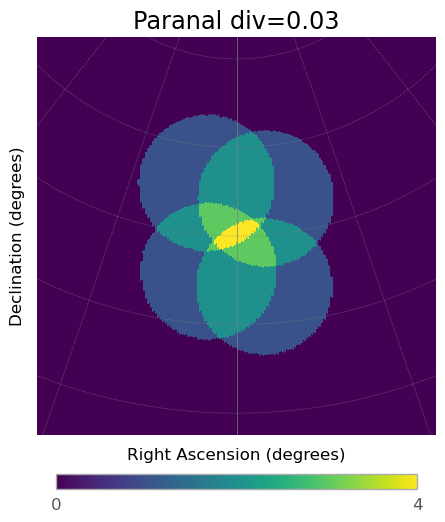

In [29]:
config_MST.multiplicity_plot()

In [30]:
table_SST_conv = []
table_SST= config_SST.table
number_of_telescopes_config_SST_first_half=[]
# Append the columns for LST so I know what to get or expect
table_SST_conv.append(table_SST['x'])
table_SST_conv.append(table_SST['y'])
table_SST_conv.append(table_SST['z'])
table_SST_conv.append(table_SST['focal'])
table_SST_conv.append(table_SST['radius'])
table_SST_conv.append(table_SST['fov'])

# Initialize sub_config and other variables
sub_config = []
telescopes = [1, 2,3,4,5,6]  # Telescope indices
# Loop through the telescopes so I can write them in a file
for tel in telescopes:
    # Putting it tel-1 because the first column we had the index
    sub_config.append([col[tel - 1] for col in table_SST_conv])
    number_of_telescopes_config_SST_first_half.append(number_of_telescopes_config_SST[tel-1])


# Print the result for verification
print(sub_config)
print(number_of_telescopes_config_SST_first_half)

[[0.0, 816.83, 21.83, 5.6, 4.450000000000001, 62.46242685852285], [-840.0, 404.67, 16.75, 5.6, 4.450000000000001, 62.46242685852285], [-840.0, -404.67, 55.92, 5.6, 4.450000000000001, 62.46242685852285], [0.0, -816.83, 65.42, 5.6, 4.450000000000001, 62.46242685852285], [839.67, -404.67, 17.75, 5.6, 4.450000000000001, 62.46242685852285], [839.67, 404.67, 10.08, 5.6, 4.450000000000001, 62.46242685852285]]
[6, 3, 3, 6, 3, 3]


In [31]:
table_SST_div = []
table_SST= config_SST.table
number_of_telescopes_config_SST_second_half=[]
# Append the columns for LST so I know what to get or expect
table_SST_div.append(table_SST['x'])
table_SST_div.append(table_SST['y'])
table_SST_div.append(table_SST['z'])
table_SST_div.append(table_SST['focal'])
table_SST_div.append(table_SST['radius'])
table_SST_div.append(table_SST['fov'])

# Initialize sub_config and other variables
sub_config_div= []
telescopes = [7,8,9,10,11,12,13]  # Telescope indices
# Loop through the telescopes so I can write them in a file
for tel in telescopes:
    # Adjust for 1-based indexing in telescopes to 0-based indexing in Python
    sub_config_div.append([col[tel - 1] for col in table_SST_div])
    number_of_telescopes_config_SST_second_half.append(number_of_telescopes_config_SST[tel-1])


# Print the result for verification
print(sub_config_div)
print(number_of_telescopes_config_SST_second_half)

[[-7.75, 0.0, 22.5, 5.6, 4.450000000000001, 62.46242685852285], [415.67, 402.0, 12.42, 5.6, 4.450000000000001, 62.46242685852285], [415.67, -402.0, 27.92, 5.6, 4.450000000000001, 62.46242685852285], [429.33, 0.0, 16.08, 5.6, 4.450000000000001, 62.46242685852285], [-415.67, -402.0, 48.25, 5.6, 4.450000000000001, 62.46242685852285], [-415.67, 402.0, 15.58, 5.6, 4.450000000000001, 62.46242685852285], [-429.67, 0.0, 29.42, 5.6, 4.450000000000001, 62.46242685852285]]
[4, 3, 3, 3, 3, 3, 3]


In [32]:
# Define the file path where you want to save the output
output_file_path_3 = './best_SST_conv.txt'

# Open the file in write mode
with open(output_file_path_3, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
   for telescope in sub_config:
        # Assuming each telescope in sub_config is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        file.write(f"{values}\n")  # Write each row of telescope data

print(f"New telescope data has been written to {output_file_path_3}")
# Define the file path where you want to save the output
output_file_path_4 = './best_SST_div.txt'

# Open the file in write mode
with open(output_file_path_4, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
   for telescope in sub_config_div:
        # Assuming each telescope in sub_config is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        file.write(f"{values}\n")  # Write each row of telescope data

print(f"New telescope data has been written to {output_file_path_4}")

New telescope data has been written to ./best_SST_conv.txt
New telescope data has been written to ./best_SST_div.txt


In [33]:
SST_config_conv= LoadConfig('./best_SST_conv.txt', frame=cta, pointing2src=True)
SST_config_div=LoadConfig('./best_SST_div.txt', frame=cta, pointing2src=True)

In [34]:
SST_config_conv.table.units= "deg"
SST_config_div.table.units= "deg"

In [35]:
SST_config_conv.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.0,816.83,21.83,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,816.88
2,-840.0,404.67,16.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.41
3,-840.0,-404.67,55.92,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.62
4,0.0,-816.83,65.42,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,817.54
5,839.67,-404.67,17.75,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.29
6,839.67,404.67,10.08,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,932.44


In [36]:
SST_config_div.table

id,x,y,z,az,alt,zn,focal,radius,fov,p_x,p_y,p_z,d_tel
,m,m,m,deg,deg,deg,m,deg,deg2,,,,m
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,-7.75,0.0,22.5,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,6.92
2,415.67,402.0,12.42,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,579.22
3,415.67,-402.0,27.92,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,579.10
4,429.33,0.0,16.08,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,430.57
5,-415.67,-402.0,48.25,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,577.91
6,-415.67,402.0,15.58,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,577.50
7,-429.67,0.0,29.42,0.000,0.000,90.000,5.600,4.450,62.462,1.000,-0.000,0.000,428.54


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  7.57it/s]
7it [00:00,  7.35it/s]
6it [00:00,  7.17it/s]


12.639706828454463


7it [00:00,  7.28it/s]


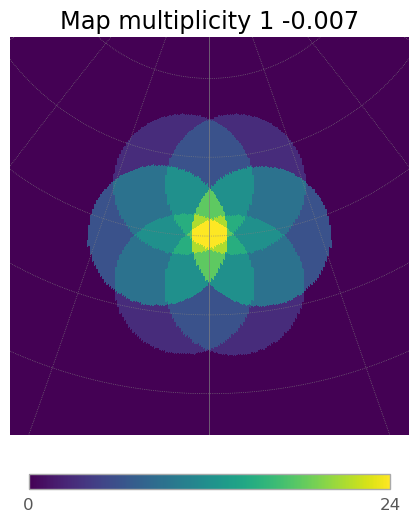

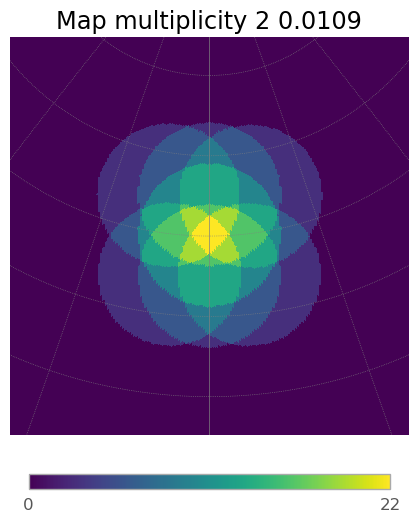

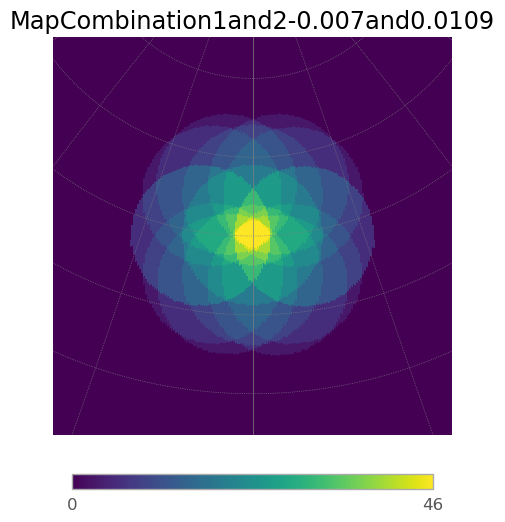

In [37]:
SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=-0.007, div2=0.0109, az=0, alt=70)
SST_config_conv.multiplicity_plot_2_div(SST_config_div, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half)


In [38]:
SST_config_conv.hFoV_for_2_arrays(array_2=SST_config_div, subarray_mult=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half)

6it [00:00,  6.94it/s]
7it [00:00,  7.28it/s]


(189.95575704505862, 15.055298584742838)

6it [00:00,  7.29it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.40it/s]
6it [00:00,  7.18it/s]


12.725284863839338


7it [00:00,  7.17it/s]
4it [00:00,  7.40it/s]


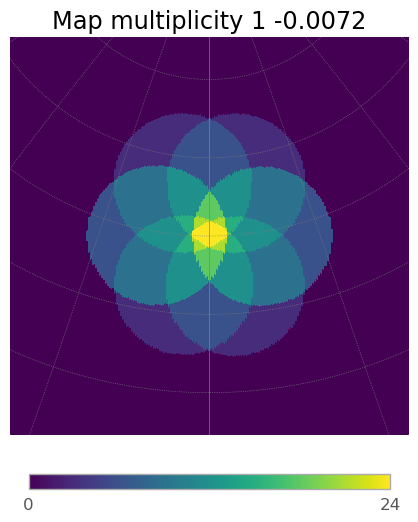

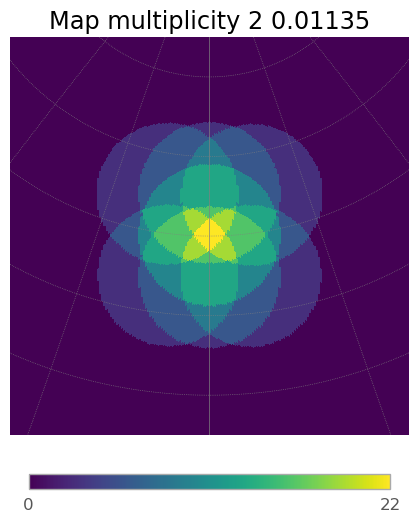

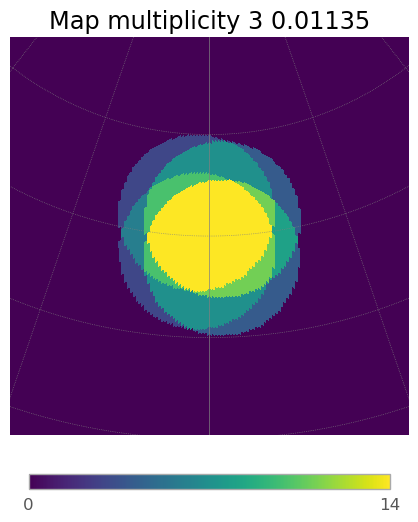

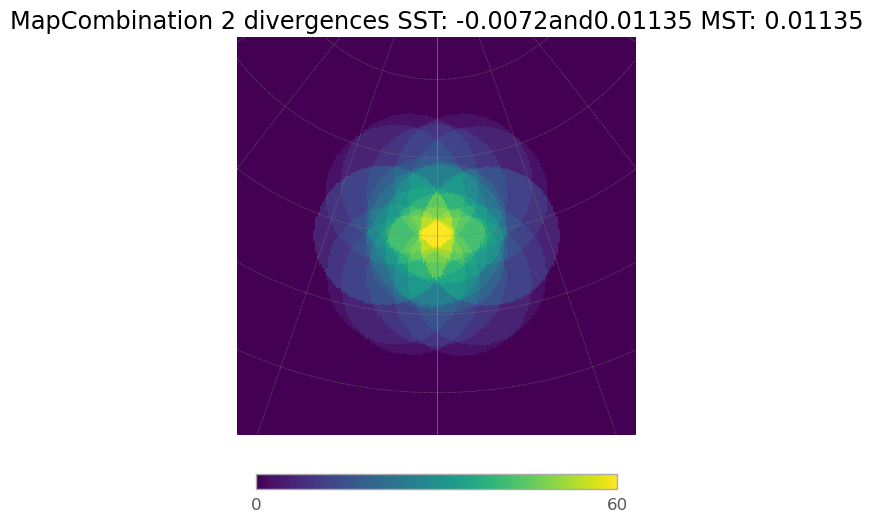

In [48]:
SST_config_conv.multiplicity_plot_3_config(array_2=SST_config_div,array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3= number_of_telescopes_subarray_1)




In [40]:
SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)

6it [00:00,  7.05it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.37it/s]


(189.95575704505862, 18.48629616845012)

In [ ]:
#From the table the ones to use for the array MST
#    0.0022
#    0.0043
#    0.008
#    0.01135
#    0.01453
# FOR THE SST the idea is to use 
#0.0022, 
#0.0043, 
#0.008, 
#0.01135, 
#0.013
#AND FOR THE CONVERGENCE TO USE: THIS WERE CALCULATED IN ORDER TO HAVE THE SAME HFOV AT THE CENTER FOR DIV AND CONV
#-0.0013434343434343427,
# -0.0026343434343434335,
# -0.005001010101010101,
# -0.007224242424242425,
# -0.0083]
#
#
#

In [62]:
div_MST=[0.0022,0.0043, 0.008, 0.01135, 0.01453]
divergence_list=[]
div_SST=np.linspace(0.001,0.014, 150)
for divergence in div_MST:
    for divergence_SST in div_SST:
        print(f" the div{divergence_SST}")
        config_MST.divergent_pointing(div=divergence, az=0, alt=70)
        hFoV_to_stop=config_MST.hFoV(m_cut=13, subarray_mult=number_of_telescopes_subarray_1 )[0]
        SST_config_div.divergent_pointing(div=divergence_SST, az=0, alt=70)
        print(f" the stop{round(hFoV_to_stop)}")
        hFoV_div=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        print(f" the div h FoV {round(hFoV_div)}")
        if round(hFoV_div) == round(hFoV_to_stop):
            divergence_list.append(divergence_SST)
            print(f"stop, the {divergence_SST}")
            break 

 the div0.001


4it [00:00,  6.76it/s]


 the stop42


7it [00:00,  7.42it/s]


 the div h FoV 54
 the div0.001087248322147651


4it [00:00,  7.39it/s]


 the stop42


7it [00:00,  7.28it/s]


 the div h FoV 54
 the div0.0011744966442953021


4it [00:00,  7.06it/s]


 the stop42


7it [00:00,  7.41it/s]


 the div h FoV 53
 the div0.001261744966442953


4it [00:00,  7.43it/s]


 the stop42


7it [00:00,  7.35it/s]


 the div h FoV 52
 the div0.001348993288590604


4it [00:00,  7.35it/s]


 the stop42


7it [00:00,  7.29it/s]


 the div h FoV 52
 the div0.001436241610738255


4it [00:00,  5.31it/s]


 the stop42


7it [00:00,  7.20it/s]


 the div h FoV 51
 the div0.0015234899328859062


4it [00:00,  7.44it/s]


 the stop42


7it [00:00,  7.28it/s]


 the div h FoV 50
 the div0.0016107382550335572


4it [00:00,  7.19it/s]


 the stop42


7it [00:00,  7.06it/s]


 the div h FoV 50
 the div0.001697986577181208


4it [00:00,  7.32it/s]


 the stop42


7it [00:00,  7.21it/s]


 the div h FoV 49
 the div0.0017852348993288593


4it [00:00,  7.27it/s]


 the stop42


7it [00:00,  7.35it/s]


 the div h FoV 48
 the div0.0018724832214765102


4it [00:00,  7.35it/s]


 the stop42


7it [00:00,  7.35it/s]


 the div h FoV 48
 the div0.0019597315436241615


4it [00:00,  7.51it/s]


 the stop42


7it [00:00,  7.43it/s]


 the div h FoV 47
 the div0.0020469798657718123


4it [00:00,  7.47it/s]


 the stop42


7it [00:00,  7.45it/s]


 the div h FoV 47
 the div0.002134228187919463


4it [00:00,  7.34it/s]


 the stop42


7it [00:00,  7.41it/s]


 the div h FoV 46
 the div0.0022214765100671144


4it [00:00,  7.35it/s]


 the stop42


7it [00:00,  7.45it/s]


 the div h FoV 45
 the div0.0023087248322147653


4it [00:00,  7.48it/s]


 the stop42


7it [00:00,  7.48it/s]


 the div h FoV 45
 the div0.002395973154362416


4it [00:00,  7.32it/s]


 the stop42


7it [00:00,  7.46it/s]


 the div h FoV 44
 the div0.0024832214765100674


4it [00:00,  7.37it/s]


 the stop42


7it [00:00,  7.53it/s]


 the div h FoV 43
 the div0.0025704697986577187


4it [00:00,  7.28it/s]


 the stop42


7it [00:00,  7.36it/s]


 the div h FoV 43
 the div0.002657718120805369


4it [00:00,  7.13it/s]


 the stop42


7it [00:00,  7.50it/s]


 the div h FoV 42
stop, the 0.002657718120805369
 the div0.001


4it [00:00,  7.16it/s]


 the stop38


7it [00:00,  7.36it/s]


 the div h FoV 54
 the div0.001087248322147651


4it [00:00,  7.54it/s]


 the stop38


7it [00:00,  7.41it/s]


 the div h FoV 54
 the div0.0011744966442953021


4it [00:00,  7.24it/s]


 the stop38


7it [00:00,  7.40it/s]


 the div h FoV 53
 the div0.001261744966442953


4it [00:00,  7.46it/s]


 the stop38


7it [00:00,  7.36it/s]


 the div h FoV 52
 the div0.001348993288590604


4it [00:00,  6.03it/s]


 the stop38


7it [00:00,  7.23it/s]


 the div h FoV 52
 the div0.001436241610738255


4it [00:00,  7.03it/s]


 the stop38


7it [00:00,  7.32it/s]


 the div h FoV 51
 the div0.0015234899328859062


4it [00:00,  7.27it/s]


 the stop38


7it [00:00,  7.41it/s]


 the div h FoV 50
 the div0.0016107382550335572


4it [00:00,  7.32it/s]


 the stop38


7it [00:00,  7.23it/s]


 the div h FoV 50
 the div0.001697986577181208


4it [00:00,  7.01it/s]


 the stop38


7it [00:00,  7.00it/s]


 the div h FoV 49
 the div0.0017852348993288593


4it [00:00,  6.89it/s]


 the stop38


7it [00:00,  7.23it/s]


 the div h FoV 48
 the div0.0018724832214765102


4it [00:00,  7.01it/s]


 the stop38


7it [00:00,  7.32it/s]


 the div h FoV 48
 the div0.0019597315436241615


4it [00:00,  7.10it/s]


 the stop38


7it [00:00,  7.02it/s]


 the div h FoV 47
 the div0.0020469798657718123


4it [00:00,  7.14it/s]


 the stop38


7it [00:00,  7.24it/s]


 the div h FoV 47
 the div0.002134228187919463


4it [00:00,  7.31it/s]


 the stop38


7it [00:00,  7.19it/s]


 the div h FoV 46
 the div0.0022214765100671144


4it [00:00,  7.20it/s]


 the stop38


7it [00:00,  7.27it/s]


 the div h FoV 45
 the div0.0023087248322147653


4it [00:00,  7.23it/s]


 the stop38


7it [00:00,  7.41it/s]


 the div h FoV 45
 the div0.002395973154362416


4it [00:00,  7.45it/s]


 the stop38


7it [00:00,  7.24it/s]


 the div h FoV 44
 the div0.0024832214765100674


4it [00:00,  7.30it/s]


 the stop38


7it [00:00,  7.34it/s]


 the div h FoV 43
 the div0.0025704697986577187


4it [00:00,  7.36it/s]


 the stop38


7it [00:00,  7.36it/s]


 the div h FoV 43
 the div0.002657718120805369


4it [00:00,  7.38it/s]


 the stop38


7it [00:00,  7.39it/s]


 the div h FoV 42
 the div0.0027449664429530203


4it [00:00,  6.66it/s]


 the stop38


7it [00:00,  7.45it/s]


 the div h FoV 42
 the div0.0028322147651006716


4it [00:00,  7.28it/s]


 the stop38


7it [00:00,  7.42it/s]


 the div h FoV 41
 the div0.0029194630872483225


4it [00:00,  7.15it/s]


 the stop38


7it [00:00,  7.34it/s]


 the div h FoV 40
 the div0.0030067114093959733


4it [00:00,  7.25it/s]


 the stop38


7it [00:00,  7.30it/s]


 the div h FoV 40
 the div0.0030939597315436246


4it [00:00,  7.16it/s]


 the stop38


7it [00:00,  7.18it/s]


 the div h FoV 39
 the div0.0031812080536912754


4it [00:00,  7.34it/s]


 the stop38


7it [00:00,  7.30it/s]


 the div h FoV 39
 the div0.0032684563758389267


4it [00:00,  7.20it/s]


 the stop38


7it [00:00,  7.41it/s]


 the div h FoV 38
stop, the 0.0032684563758389267
 the div0.001


4it [00:00,  7.42it/s]


 the stop31


7it [00:00,  7.07it/s]


 the div h FoV 54
 the div0.001087248322147651


4it [00:00,  7.33it/s]


 the stop31


7it [00:00,  7.35it/s]


 the div h FoV 54
 the div0.0011744966442953021


4it [00:00,  7.40it/s]


 the stop31


7it [00:00,  7.40it/s]


 the div h FoV 53
 the div0.001261744966442953


4it [00:00,  7.45it/s]


 the stop31


7it [00:00,  7.35it/s]


 the div h FoV 52
 the div0.001348993288590604


4it [00:00,  7.31it/s]


 the stop31


7it [00:00,  7.35it/s]


 the div h FoV 52
 the div0.001436241610738255


4it [00:00,  7.38it/s]


 the stop31


7it [00:00,  7.33it/s]


 the div h FoV 51
 the div0.0015234899328859062


4it [00:00,  7.32it/s]


 the stop31


7it [00:00,  7.30it/s]


 the div h FoV 50
 the div0.0016107382550335572


4it [00:00,  7.23it/s]


 the stop31


7it [00:00,  7.06it/s]


 the div h FoV 50
 the div0.001697986577181208


4it [00:00,  5.42it/s]


 the stop31


7it [00:00,  7.31it/s]


 the div h FoV 49
 the div0.0017852348993288593


4it [00:00,  6.65it/s]


 the stop31


7it [00:00,  7.19it/s]


 the div h FoV 48
 the div0.0018724832214765102


4it [00:00,  6.96it/s]


 the stop31


7it [00:00,  7.19it/s]


 the div h FoV 48
 the div0.0019597315436241615


4it [00:00,  7.38it/s]


 the stop31


7it [00:00,  7.37it/s]


 the div h FoV 47
 the div0.0020469798657718123


4it [00:00,  7.17it/s]


 the stop31


7it [00:00,  7.41it/s]


 the div h FoV 47
 the div0.002134228187919463


4it [00:00,  7.26it/s]


 the stop31


7it [00:00,  7.42it/s]


 the div h FoV 46
 the div0.0022214765100671144


4it [00:00,  7.16it/s]


 the stop31


7it [00:00,  7.34it/s]


 the div h FoV 45
 the div0.0023087248322147653


4it [00:00,  7.33it/s]


 the stop31


7it [00:00,  7.41it/s]


 the div h FoV 45
 the div0.002395973154362416


4it [00:00,  7.38it/s]


 the stop31


7it [00:00,  7.31it/s]


 the div h FoV 44
 the div0.0024832214765100674


4it [00:00,  7.39it/s]


 the stop31


7it [00:00,  7.39it/s]


 the div h FoV 43
 the div0.0025704697986577187


4it [00:00,  7.10it/s]


 the stop31


7it [00:00,  7.17it/s]


 the div h FoV 43
 the div0.002657718120805369


4it [00:00,  7.50it/s]


 the stop31


7it [00:00,  7.46it/s]


 the div h FoV 42
 the div0.0027449664429530203


4it [00:00,  7.36it/s]


 the stop31


7it [00:00,  7.35it/s]


 the div h FoV 42
 the div0.0028322147651006716


4it [00:00,  7.40it/s]


 the stop31


7it [00:00,  7.32it/s]


 the div h FoV 41
 the div0.0029194630872483225


4it [00:00,  7.32it/s]


 the stop31


7it [00:00,  7.31it/s]


 the div h FoV 40
 the div0.0030067114093959733


4it [00:00,  7.42it/s]


 the stop31


7it [00:00,  7.50it/s]


 the div h FoV 40
 the div0.0030939597315436246


4it [00:00,  7.23it/s]


 the stop31


7it [00:00,  7.42it/s]


 the div h FoV 39
 the div0.0031812080536912754


4it [00:00,  7.32it/s]


 the stop31


7it [00:01,  6.31it/s]


 the div h FoV 39
 the div0.0032684563758389267


4it [00:00,  7.38it/s]


 the stop31


7it [00:00,  7.45it/s]


 the div h FoV 38
 the div0.0033557046979865775


4it [00:00,  7.24it/s]


 the stop31


7it [00:00,  7.47it/s]


 the div h FoV 37
 the div0.0034429530201342284


4it [00:00,  7.30it/s]


 the stop31


7it [00:00,  7.39it/s]


 the div h FoV 37
 the div0.0035302013422818797


4it [00:00,  7.45it/s]


 the stop31


7it [00:00,  7.34it/s]


 the div h FoV 36
 the div0.0036174496644295305


4it [00:00,  7.51it/s]


 the stop31


7it [00:00,  7.32it/s]


 the div h FoV 36
 the div0.0037046979865771818


4it [00:00,  7.28it/s]


 the stop31


7it [00:00,  7.51it/s]


 the div h FoV 35
 the div0.0037919463087248326


4it [00:00,  7.34it/s]


 the stop31


7it [00:00,  7.45it/s]


 the div h FoV 35
 the div0.0038791946308724835


4it [00:00,  7.50it/s]


 the stop31


7it [00:00,  7.30it/s]


 the div h FoV 34
 the div0.003966442953020135


4it [00:00,  7.17it/s]


 the stop31


7it [00:00,  7.40it/s]


 the div h FoV 34
 the div0.004053691275167786


4it [00:00,  7.41it/s]


 the stop31


7it [00:00,  7.38it/s]


 the div h FoV 33
 the div0.004140939597315436


4it [00:00,  7.44it/s]


 the stop31


7it [00:00,  7.26it/s]


 the div h FoV 33
 the div0.004228187919463088


4it [00:00,  7.23it/s]


 the stop31


7it [00:00,  7.44it/s]


 the div h FoV 32
 the div0.004315436241610739


4it [00:00,  7.42it/s]


 the stop31


7it [00:00,  7.48it/s]


 the div h FoV 31
stop, the 0.004315436241610739
 the div0.001


4it [00:00,  7.43it/s]


 the stop25


7it [00:00,  7.51it/s]


 the div h FoV 54
 the div0.001087248322147651


4it [00:00,  7.42it/s]


 the stop25


7it [00:00,  7.53it/s]


 the div h FoV 54
 the div0.0011744966442953021


4it [00:00,  7.40it/s]


 the stop25


7it [00:00,  7.24it/s]


 the div h FoV 53
 the div0.001261744966442953


4it [00:00,  7.41it/s]


 the stop25


7it [00:00,  7.29it/s]


 the div h FoV 52
 the div0.001348993288590604


4it [00:00,  6.87it/s]


 the stop25


7it [00:00,  7.19it/s]


 the div h FoV 52
 the div0.001436241610738255


4it [00:00,  7.17it/s]


 the stop25


7it [00:00,  7.22it/s]


 the div h FoV 51
 the div0.0015234899328859062


4it [00:00,  7.19it/s]


 the stop25


7it [00:00,  7.41it/s]


 the div h FoV 50
 the div0.0016107382550335572


4it [00:00,  7.34it/s]


 the stop25


7it [00:00,  7.36it/s]


 the div h FoV 50
 the div0.001697986577181208


4it [00:00,  6.97it/s]


 the stop25


7it [00:01,  6.95it/s]


 the div h FoV 49
 the div0.0017852348993288593


4it [00:00,  7.31it/s]


 the stop25


7it [00:00,  7.14it/s]


 the div h FoV 48
 the div0.0018724832214765102


4it [00:00,  7.44it/s]


 the stop25


7it [00:00,  7.39it/s]


 the div h FoV 48
 the div0.0019597315436241615


4it [00:00,  7.19it/s]


 the stop25


7it [00:00,  7.34it/s]


 the div h FoV 47
 the div0.0020469798657718123


4it [00:00,  7.37it/s]


 the stop25


7it [00:00,  7.22it/s]


 the div h FoV 47
 the div0.002134228187919463


4it [00:00,  6.39it/s]


 the stop25


7it [00:01,  6.99it/s]


 the div h FoV 46
 the div0.0022214765100671144


4it [00:00,  7.29it/s]


 the stop25


7it [00:00,  7.09it/s]


 the div h FoV 45
 the div0.0023087248322147653


4it [00:00,  6.96it/s]


 the stop25


7it [00:00,  7.12it/s]


 the div h FoV 45
 the div0.002395973154362416


4it [00:00,  7.26it/s]


 the stop25


7it [00:00,  7.39it/s]


 the div h FoV 44
 the div0.0024832214765100674


4it [00:00,  7.28it/s]


 the stop25


7it [00:00,  7.14it/s]


 the div h FoV 43
 the div0.0025704697986577187


4it [00:00,  7.36it/s]


 the stop25


7it [00:00,  7.08it/s]


 the div h FoV 43
 the div0.002657718120805369


4it [00:00,  7.26it/s]


 the stop25


7it [00:00,  7.34it/s]


 the div h FoV 42
 the div0.0027449664429530203


4it [00:00,  7.33it/s]


 the stop25


7it [00:00,  7.21it/s]


 the div h FoV 42
 the div0.0028322147651006716


4it [00:00,  7.39it/s]


 the stop25


7it [00:00,  7.33it/s]


 the div h FoV 41
 the div0.0029194630872483225


4it [00:00,  7.37it/s]


 the stop25


7it [00:00,  7.39it/s]


 the div h FoV 40
 the div0.0030067114093959733


4it [00:00,  7.36it/s]


 the stop25


7it [00:00,  7.26it/s]


 the div h FoV 40
 the div0.0030939597315436246


4it [00:00,  7.40it/s]


 the stop25


7it [00:00,  7.38it/s]


 the div h FoV 39
 the div0.0031812080536912754


4it [00:00,  7.28it/s]


 the stop25


7it [00:00,  7.45it/s]


 the div h FoV 39
 the div0.0032684563758389267


4it [00:00,  7.38it/s]


 the stop25


7it [00:00,  7.31it/s]


 the div h FoV 38
 the div0.0033557046979865775


4it [00:00,  7.31it/s]


 the stop25


7it [00:00,  7.37it/s]


 the div h FoV 37
 the div0.0034429530201342284


4it [00:00,  7.42it/s]


 the stop25


7it [00:00,  7.50it/s]


 the div h FoV 37
 the div0.0035302013422818797


4it [00:00,  5.82it/s]


 the stop25


7it [00:00,  7.24it/s]


 the div h FoV 36
 the div0.0036174496644295305


4it [00:00,  7.35it/s]


 the stop25


7it [00:00,  7.39it/s]


 the div h FoV 36
 the div0.0037046979865771818


4it [00:00,  7.35it/s]


 the stop25


7it [00:00,  7.29it/s]


 the div h FoV 35
 the div0.0037919463087248326


4it [00:00,  7.23it/s]


 the stop25


7it [00:00,  7.37it/s]


 the div h FoV 35
 the div0.0038791946308724835


4it [00:00,  7.20it/s]


 the stop25


7it [00:00,  7.44it/s]


 the div h FoV 34
 the div0.003966442953020135


4it [00:00,  7.15it/s]


 the stop25


7it [00:00,  7.31it/s]


 the div h FoV 34
 the div0.004053691275167786


4it [00:00,  7.29it/s]


 the stop25


7it [00:00,  7.30it/s]


 the div h FoV 33
 the div0.004140939597315436


4it [00:00,  7.33it/s]


 the stop25


7it [00:00,  7.40it/s]


 the div h FoV 33
 the div0.004228187919463088


4it [00:00,  7.38it/s]


 the stop25


7it [00:00,  7.38it/s]


 the div h FoV 32
 the div0.004315436241610739


4it [00:00,  7.21it/s]


 the stop25


7it [00:00,  7.43it/s]


 the div h FoV 31
 the div0.004402684563758389


4it [00:00,  7.37it/s]


 the stop25


7it [00:00,  7.42it/s]


 the div h FoV 31
 the div0.004489932885906041


4it [00:00,  7.30it/s]


 the stop25


7it [00:00,  7.43it/s]


 the div h FoV 30
 the div0.004577181208053692


4it [00:00,  7.16it/s]


 the stop25


7it [00:00,  7.38it/s]


 the div h FoV 30
 the div0.004664429530201342


4it [00:00,  7.35it/s]


 the stop25


7it [00:00,  7.37it/s]


 the div h FoV 29
 the div0.004751677852348994


4it [00:00,  7.47it/s]


 the stop25


7it [00:00,  7.35it/s]


 the div h FoV 29
 the div0.004838926174496645


4it [00:00,  7.30it/s]


 the stop25


7it [00:00,  7.33it/s]


 the div h FoV 28
 the div0.004926174496644296


4it [00:00,  7.24it/s]


 the stop25


7it [00:00,  7.45it/s]


 the div h FoV 28
 the div0.005013422818791947


4it [00:00,  7.38it/s]


 the stop25


7it [00:00,  7.36it/s]


 the div h FoV 27
 the div0.005100671140939598


4it [00:00,  7.19it/s]


 the stop25


7it [00:00,  7.48it/s]


 the div h FoV 27
 the div0.005187919463087249


4it [00:00,  7.33it/s]


 the stop25


7it [00:00,  7.37it/s]


 the div h FoV 26
 the div0.0052751677852348995


4it [00:00,  7.37it/s]


 the stop25


7it [00:00,  7.33it/s]


 the div h FoV 26
 the div0.005362416107382551


4it [00:00,  7.28it/s]


 the stop25


7it [00:00,  7.26it/s]


 the div h FoV 25
stop, the 0.005362416107382551
 the div0.001


4it [00:00,  6.95it/s]


 the stop20


7it [00:01,  6.24it/s]


 the div h FoV 54
 the div0.001087248322147651


4it [00:00,  7.18it/s]


 the stop20


7it [00:00,  7.31it/s]


 the div h FoV 54
 the div0.0011744966442953021


4it [00:00,  7.31it/s]


 the stop20


7it [00:00,  7.28it/s]


 the div h FoV 53
 the div0.001261744966442953


4it [00:00,  7.37it/s]


 the stop20


7it [00:00,  7.42it/s]


 the div h FoV 52
 the div0.001348993288590604


4it [00:00,  7.43it/s]


 the stop20


7it [00:00,  7.45it/s]


 the div h FoV 52
 the div0.001436241610738255


4it [00:00,  7.33it/s]


 the stop20


7it [00:00,  7.26it/s]


 the div h FoV 51
 the div0.0015234899328859062


4it [00:00,  7.13it/s]


 the stop20


7it [00:00,  7.35it/s]


 the div h FoV 50
 the div0.0016107382550335572


4it [00:00,  7.44it/s]


 the stop20


7it [00:00,  7.33it/s]


 the div h FoV 50
 the div0.001697986577181208


4it [00:00,  7.28it/s]


 the stop20


7it [00:00,  7.21it/s]


 the div h FoV 49
 the div0.0017852348993288593


4it [00:00,  7.31it/s]


 the stop20


7it [00:00,  7.45it/s]


 the div h FoV 48
 the div0.0018724832214765102


4it [00:00,  7.39it/s]


 the stop20


7it [00:00,  7.42it/s]


 the div h FoV 48
 the div0.0019597315436241615


4it [00:00,  7.23it/s]


 the stop20


7it [00:00,  7.23it/s]


 the div h FoV 47
 the div0.0020469798657718123


4it [00:00,  7.37it/s]


 the stop20


7it [00:00,  7.40it/s]


 the div h FoV 47
 the div0.002134228187919463


4it [00:00,  7.34it/s]


 the stop20


7it [00:00,  7.22it/s]


 the div h FoV 46
 the div0.0022214765100671144


4it [00:00,  7.34it/s]


 the stop20


7it [00:00,  7.22it/s]


 the div h FoV 45
 the div0.0023087248322147653


4it [00:00,  7.42it/s]


 the stop20


7it [00:00,  7.38it/s]


 the div h FoV 45
 the div0.002395973154362416


4it [00:00,  7.34it/s]


 the stop20


7it [00:00,  7.16it/s]


 the div h FoV 44
 the div0.0024832214765100674


4it [00:00,  7.28it/s]


 the stop20


7it [00:00,  7.39it/s]


 the div h FoV 43
 the div0.0025704697986577187


4it [00:00,  7.21it/s]


 the stop20


7it [00:00,  7.46it/s]


 the div h FoV 43
 the div0.002657718120805369


4it [00:00,  7.36it/s]


 the stop20


7it [00:00,  7.38it/s]


 the div h FoV 42
 the div0.0027449664429530203


4it [00:00,  7.36it/s]


 the stop20


7it [00:00,  7.44it/s]


 the div h FoV 42
 the div0.0028322147651006716


4it [00:00,  7.48it/s]


 the stop20


7it [00:00,  7.37it/s]


 the div h FoV 41
 the div0.0029194630872483225


4it [00:00,  5.42it/s]


 the stop20


7it [00:00,  7.15it/s]


 the div h FoV 40
 the div0.0030067114093959733


4it [00:00,  7.26it/s]


 the stop20


7it [00:00,  7.27it/s]


 the div h FoV 40
 the div0.0030939597315436246


4it [00:00,  7.40it/s]


 the stop20


7it [00:00,  7.41it/s]


 the div h FoV 39
 the div0.0031812080536912754


4it [00:00,  7.37it/s]


 the stop20


7it [00:00,  7.47it/s]


 the div h FoV 39
 the div0.0032684563758389267


4it [00:00,  7.26it/s]


 the stop20


7it [00:00,  7.32it/s]


 the div h FoV 38
 the div0.0033557046979865775


4it [00:00,  7.40it/s]


 the stop20


7it [00:00,  7.43it/s]


 the div h FoV 37
 the div0.0034429530201342284


4it [00:00,  7.41it/s]


 the stop20


7it [00:00,  7.27it/s]


 the div h FoV 37
 the div0.0035302013422818797


4it [00:00,  7.33it/s]


 the stop20


7it [00:00,  7.40it/s]


 the div h FoV 36
 the div0.0036174496644295305


4it [00:00,  7.30it/s]


 the stop20


7it [00:00,  7.28it/s]


 the div h FoV 36
 the div0.0037046979865771818


4it [00:00,  7.50it/s]


 the stop20


7it [00:00,  7.49it/s]


 the div h FoV 35
 the div0.0037919463087248326


4it [00:00,  7.34it/s]


 the stop20


7it [00:01,  6.95it/s]


 the div h FoV 35
 the div0.0038791946308724835


4it [00:00,  7.29it/s]


 the stop20


7it [00:00,  7.30it/s]


 the div h FoV 34
 the div0.003966442953020135


4it [00:00,  7.35it/s]


 the stop20


7it [00:00,  7.40it/s]


 the div h FoV 34
 the div0.004053691275167786


4it [00:00,  7.34it/s]


 the stop20


7it [00:00,  7.35it/s]


 the div h FoV 33
 the div0.004140939597315436


4it [00:00,  7.39it/s]


 the stop20


7it [00:00,  7.44it/s]


 the div h FoV 33
 the div0.004228187919463088


4it [00:00,  7.51it/s]


 the stop20


7it [00:00,  7.35it/s]


 the div h FoV 32
 the div0.004315436241610739


4it [00:00,  7.33it/s]


 the stop20


7it [00:00,  7.26it/s]


 the div h FoV 31
 the div0.004402684563758389


4it [00:00,  7.31it/s]


 the stop20


7it [00:00,  7.35it/s]


 the div h FoV 31
 the div0.004489932885906041


4it [00:00,  7.31it/s]


 the stop20


7it [00:01,  6.38it/s]


 the div h FoV 30
 the div0.004577181208053692


4it [00:00,  7.33it/s]


 the stop20


7it [00:00,  7.46it/s]


 the div h FoV 30
 the div0.004664429530201342


4it [00:00,  7.26it/s]


 the stop20


7it [00:00,  7.29it/s]


 the div h FoV 29
 the div0.004751677852348994


4it [00:00,  7.37it/s]


 the stop20


7it [00:00,  7.42it/s]


 the div h FoV 29
 the div0.004838926174496645


4it [00:00,  7.39it/s]


 the stop20


7it [00:00,  7.38it/s]


 the div h FoV 28
 the div0.004926174496644296


4it [00:00,  7.39it/s]


 the stop20


7it [00:00,  7.37it/s]


 the div h FoV 28
 the div0.005013422818791947


4it [00:00,  7.42it/s]


 the stop20


7it [00:00,  7.27it/s]


 the div h FoV 27
 the div0.005100671140939598


4it [00:00,  7.41it/s]


 the stop20


7it [00:00,  7.41it/s]


 the div h FoV 27
 the div0.005187919463087249


4it [00:00,  7.19it/s]


 the stop20


7it [00:00,  7.18it/s]


 the div h FoV 26
 the div0.0052751677852348995


4it [00:00,  7.20it/s]


 the stop20


7it [00:00,  7.29it/s]


 the div h FoV 26
 the div0.005362416107382551


4it [00:00,  7.29it/s]


 the stop20


7it [00:00,  7.47it/s]


 the div h FoV 25
 the div0.005449664429530202


4it [00:00,  7.23it/s]


 the stop20


7it [00:00,  7.32it/s]


 the div h FoV 25
 the div0.005536912751677853


4it [00:00,  7.38it/s]


 the stop20


7it [00:00,  7.45it/s]


 the div h FoV 24
 the div0.005624161073825504


4it [00:00,  7.23it/s]


 the stop20


7it [00:00,  7.43it/s]


 the div h FoV 24
 the div0.005711409395973155


4it [00:00,  7.24it/s]


 the stop20


7it [00:00,  7.29it/s]


 the div h FoV 23
 the div0.005798657718120806


4it [00:00,  7.21it/s]


 the stop20


7it [00:00,  7.37it/s]


 the div h FoV 23
 the div0.005885906040268457


4it [00:00,  7.31it/s]


 the stop20


7it [00:00,  7.51it/s]


 the div h FoV 22
 the div0.005973154362416108


4it [00:00,  7.31it/s]


 the stop20


7it [00:00,  7.45it/s]


 the div h FoV 22
 the div0.006060402684563759


4it [00:00,  7.35it/s]


 the stop20


7it [00:01,  6.11it/s]


 the div h FoV 22
 the div0.00614765100671141


4it [00:00,  7.32it/s]


 the stop20


7it [00:00,  7.44it/s]


 the div h FoV 21
 the div0.006234899328859061


4it [00:00,  7.35it/s]


 the stop20


7it [00:00,  7.21it/s]


 the div h FoV 21
 the div0.006322147651006712


4it [00:00,  7.24it/s]


 the stop20


7it [00:00,  7.36it/s]

 the div h FoV 20
stop, the 0.006322147651006712


In [69]:
conv=np.linspace(-0.0083,-0.0012, 100)
convergence_list=[]
for divergence in divergence_list:
    for convergence in conv:
        SST_config_div.divergent_pointing(div=divergence, az=0, alt=70)
        hFoV_to_stop=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        SST_config_conv.divergent_pointing(div=convergence, az=0, alt=70)
        hFoV_conv=SST_config_conv.hFoV(subarray_mult=number_of_telescopes_config_SST_first_half,m_cut=23)[0]
        if hFoV_conv > hFoV_to_stop:
            convergence_list.append(convergence)
            print(f"stop, the {convergence}")
            break 

7it [00:00,  7.16it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.53it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.30it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.22it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.19it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.22it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.50it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.21it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  6.97it/s]
7it [00:00,  7.33it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.42it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.28it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.37it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.13it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.19it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.32it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.00it/s]
7it [00:00,  7.36it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.10it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.41it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.41it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.49it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.17it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.11it/s]
7it [00:01,  6.96it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  6.91it/s]
7it [00:00,  7.14it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.09it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.14it/s]
7it [00:00,  7.01it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.04it/s]
7it [00:00,  7.34it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  6.96it/s]
7it [00:00,  7.22it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.12it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.32it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.55it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.52it/s]
7it [00:00,  7.47it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.51it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.42it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.56it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.44it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.32it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  7.55it/s]
7it [00:00,  7.50it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.45it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.46it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.34it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.39it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.49it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.51it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.46it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.52it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.47it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.35it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.52it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.48it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  7.58it/s]
7it [00:00,  7.55it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.46it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.53it/s]
7it [00:00,  7.37it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.45it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.17it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  6.84it/s]
7it [00:00,  7.27it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.14it/s]
7it [00:01,  6.95it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.10it/s]
7it [00:00,  7.20it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.15it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.42it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.16it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.31it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.36it/s]
7it [00:01,  6.93it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.41it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:00,  7.12it/s]
7it [00:00,  7.38it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.35it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:00,  7.05it/s]
7it [00:00,  7.13it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.18it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.44it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.29it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.40it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.36it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:00,  6.98it/s]
7it [00:00,  7.45it/s]


-6.2067164950299265 rad
-6.248014310135704 rad
-0.035170997043882046 rad
-0.07646881214965973 rad
-0.04117970650541514 rad
-6.242005600674171 rad


6it [00:00,  7.17it/s]
7it [00:00,  7.49it/s]


-6.208419566234827 rad
-6.2487437613536 rad
-0.0344415458259868 rad
-0.07476574094475863 rad
-0.04018339618278599 rad
-6.2430019109968 rad


6it [00:00,  7.51it/s]
7it [00:00,  7.38it/s]


-6.210123070133323 rad
-6.249475638463455 rad
-0.03370966871613179 rad
-0.0730622370462628 rad
-0.039190801556554966 rad
-6.243994505623031 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.39it/s]


-6.211826997026035 rad
-6.250209952810261 rad
-0.03297535436932497 rad
-0.07135831015355132 rad
-0.03820190380888322 rad
-6.2449834033707035 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.55it/s]


-6.213531337198955 rad
-6.250946715804261 rad
-0.03223859137532514 rad
-0.069653969980632 rad
-0.03721668423303548 rad
-6.245968622946551 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.48it/s]


-6.21523608092377 rad
-6.251685938921361 rad
-0.03149936825822497 rad
-0.06794922625581634 rad
-0.036235124232727234 rad
-6.246950182946859 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.36it/s]


-6.216941218458192 rad
-6.252427633703556 rad
-0.03075767347602998 rad
-0.06624408872139353 rad
-0.035257205321472807 rad
-6.247928101858113 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.29it/s]


-6.218646740046284 rad
-6.253171811759353 rad
-0.030013495420233127 rad
-0.06453856713330186 rad
-0.034282909121938765 rad
-6.2489023980576475 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.30it/s]


-6.220352635918786 rad
-6.253918484764196 rad
-0.029266822415389804 rad
-0.06283267126080005 rad
-0.03331221736529688 rad
-6.249873089814289 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.49it/s]


-6.22205889629345 rad
-6.254667664460898 rad
-0.028517642718687952 rad
-0.06112641088613646 rad
-0.03234511189058287 rad
-6.250840195289003 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.26it/s]


-6.223765511375367 rad
-6.255419362660069 rad
-0.02776594451951686 rad
-0.05941979580421952 rad
-0.03138157464405378 rad
-6.2518037325355325 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.45it/s]


-6.225472471357303 rad
-6.256173591240556 rad
-0.027011715939030623 rad
-0.05771283582228337 rad
-0.0304215876785503 rad
-6.252763719501036 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.50it/s]


-6.227179766420031 rad
-6.2569303621498715 rad
-0.02625494502971426 rad
-0.05600554075955566 rad
-0.029465133152861256 rad
-6.253720174026725 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.55it/s]


-6.228887386732663 rad
-6.257689687404646 rad
-0.025495619774940526 rad
-0.054297920446923165 rad
-0.028512193331089897 rad
-6.254673113848496 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.46it/s]


-6.2305953224529915 rad
-6.258451579091059 rad
-0.02473372808852803 rad
-0.05258998472659515 rad
-0.027562750582022844 rad
-6.255622556597563 rad


6it [00:00,  7.22it/s]
7it [00:01,  6.68it/s]


-6.232303563727818 rad
-6.259216049365289 rad
-0.023969257814297595 rad
-0.0508817434517681 rad
-0.026616787378503037 rad
-6.256568519801084 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.47it/s]


-6.234012100693299 rad
-6.259983110453965 rad
-0.02320219672562107 rad
-0.04917320648628776 rad
-0.025674286296803572 rad
-6.257511020882783 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.32it/s]


-6.235720923475275 rad
-6.2607527746546126 rad
-0.02243253252497368 rad
-0.04746438370431161 rad
-0.024735230016004195 rad
-6.258450077163582 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.28it/s]


-6.237430022189618 rad
-6.26152505433611 rad
-0.021660252843476613 rad
-0.04575528498996828 rad
-0.023799601317372687 rad
-6.259385705862213 rad


6it [00:00,  7.13it/s]
7it [00:00,  7.52it/s]


-6.2391393869425675 rad
-6.262299961939142 rad
-0.020885345240444497 rad
-0.0440459202370187 rad
-0.022867383083744475 rad
-6.260317924095842 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.43it/s]


-6.240849007831072 rad
-6.2630775099766645 rad
-0.020107797202922217 rad
-0.04233629934851413 rad
-0.021938558298912003 rad
-6.261246748880675 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.35it/s]


-6.242558874943131 rad
-6.26385771103436 rad
-0.01932759614522661 rad
-0.04062643223645512 rad
-0.0210131100470079 rad
-6.262172197132578 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.44it/s]


-6.2442689783581375 rad
-6.264640577771107 rad
-0.018544729408478844 rad
-0.03891632882144913 rad
-0.020091021511898788 rad
-6.2630942856676874 rad


6it [00:00,  7.22it/s]


stop, the -0.0016303030303030297


7it [00:00,  7.14it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.14it/s]
7it [00:01,  6.80it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.92it/s]
7it [00:00,  7.23it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.45it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.32it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.19it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.14it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.34it/s]
7it [00:01,  6.94it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.14it/s]
7it [00:01,  6.94it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.34it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.26it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.47it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.12it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.27it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.44it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.39it/s]
7it [00:01,  6.23it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.41it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.07it/s]
7it [00:00,  7.20it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.21it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.32it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.37it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.34it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.43it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.43it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.49it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.37it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.43it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.30it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.48it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.06it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.53it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.29it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.45it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.53it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.42it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.46it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.46it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  7.14it/s]
7it [00:00,  7.33it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.36it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.13it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.26it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.41it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.55it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.29it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  6.26it/s]
7it [00:00,  7.42it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.29it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.42it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.50it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.41it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.43it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.35it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.46it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.54it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.38it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.36it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.36it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.46it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.45it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.16it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.36it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.38it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.30it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.23it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.34it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.44it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.37it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.34it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.43it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.45it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.46it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.27it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.51it/s]


-6.2067164950299265 rad
-6.248014310135704 rad
-0.035170997043882046 rad
-0.07646881214965973 rad
-0.04117970650541514 rad
-6.242005600674171 rad


6it [00:00,  7.26it/s]
7it [00:01,  6.97it/s]


-6.208419566234827 rad
-6.2487437613536 rad
-0.0344415458259868 rad
-0.07476574094475863 rad
-0.04018339618278599 rad
-6.2430019109968 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.29it/s]


-6.210123070133323 rad
-6.249475638463455 rad
-0.03370966871613179 rad
-0.0730622370462628 rad
-0.039190801556554966 rad
-6.243994505623031 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.40it/s]


-6.211826997026035 rad
-6.250209952810261 rad
-0.03297535436932497 rad
-0.07135831015355132 rad
-0.03820190380888322 rad
-6.2449834033707035 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.51it/s]


-6.213531337198955 rad
-6.250946715804261 rad
-0.03223859137532514 rad
-0.069653969980632 rad
-0.03721668423303548 rad
-6.245968622946551 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.50it/s]


-6.21523608092377 rad
-6.251685938921361 rad
-0.03149936825822497 rad
-0.06794922625581634 rad
-0.036235124232727234 rad
-6.246950182946859 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.39it/s]


-6.216941218458192 rad
-6.252427633703556 rad
-0.03075767347602998 rad
-0.06624408872139353 rad
-0.035257205321472807 rad
-6.247928101858113 rad


6it [00:00,  7.55it/s]
7it [00:00,  7.25it/s]


-6.218646740046284 rad
-6.253171811759353 rad
-0.030013495420233127 rad
-0.06453856713330186 rad
-0.034282909121938765 rad
-6.2489023980576475 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.42it/s]


-6.220352635918786 rad
-6.253918484764196 rad
-0.029266822415389804 rad
-0.06283267126080005 rad
-0.03331221736529688 rad
-6.249873089814289 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.48it/s]


-6.22205889629345 rad
-6.254667664460898 rad
-0.028517642718687952 rad
-0.06112641088613646 rad
-0.03234511189058287 rad
-6.250840195289003 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.44it/s]


-6.223765511375367 rad
-6.255419362660069 rad
-0.02776594451951686 rad
-0.05941979580421952 rad
-0.03138157464405378 rad
-6.2518037325355325 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.45it/s]


-6.225472471357303 rad
-6.256173591240556 rad
-0.027011715939030623 rad
-0.05771283582228337 rad
-0.0304215876785503 rad
-6.252763719501036 rad


6it [00:00,  6.96it/s]
7it [00:00,  7.49it/s]


-6.227179766420031 rad
-6.2569303621498715 rad
-0.02625494502971426 rad
-0.05600554075955566 rad
-0.029465133152861256 rad
-6.253720174026725 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.39it/s]


-6.228887386732663 rad
-6.257689687404646 rad
-0.025495619774940526 rad
-0.054297920446923165 rad
-0.028512193331089897 rad
-6.254673113848496 rad


6it [00:00,  7.13it/s]
7it [00:00,  7.27it/s]


-6.2305953224529915 rad
-6.258451579091059 rad
-0.02473372808852803 rad
-0.05258998472659515 rad
-0.027562750582022844 rad
-6.255622556597563 rad


6it [00:00,  6.99it/s]
7it [00:01,  6.86it/s]


-6.232303563727818 rad
-6.259216049365289 rad
-0.023969257814297595 rad
-0.0508817434517681 rad
-0.026616787378503037 rad
-6.256568519801084 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.16it/s]


-6.234012100693299 rad
-6.259983110453965 rad
-0.02320219672562107 rad
-0.04917320648628776 rad
-0.025674286296803572 rad
-6.257511020882783 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.35it/s]


-6.235720923475275 rad
-6.2607527746546126 rad
-0.02243253252497368 rad
-0.04746438370431161 rad
-0.024735230016004195 rad
-6.258450077163582 rad


6it [00:00,  7.28it/s]


stop, the -0.001988888888888888


7it [00:00,  7.39it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.46it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.50it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.36it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.41it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.36it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.47it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.38it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.33it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.48it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.49it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.05it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.47it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.37it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  6.94it/s]
7it [00:00,  7.34it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.38it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.40it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.36it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.49it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.34it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.52it/s]
7it [00:00,  7.45it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.45it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.39it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.31it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.49it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.51it/s]
7it [00:01,  6.85it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.22it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.36it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.40it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.48it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.46it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.49it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.39it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.40it/s]
7it [00:01,  6.93it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.53it/s]
7it [00:00,  7.50it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.27it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.38it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  7.23it/s]
7it [00:00,  7.40it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.42it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.19it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  6.17it/s]
7it [00:00,  7.35it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.39it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.39it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.44it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.33it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.37it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.44it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.50it/s]
7it [00:00,  7.18it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.35it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  7.50it/s]
7it [00:00,  7.44it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.51it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.12it/s]
7it [00:00,  7.01it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.11it/s]
7it [00:01,  6.97it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.02it/s]
7it [00:00,  7.06it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  7.10it/s]
7it [00:00,  7.20it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.28it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.07it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.42it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.49it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.44it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.38it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.48it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.40it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.37it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  7.11it/s]
7it [00:01,  6.91it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:00,  6.78it/s]
7it [00:00,  7.15it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.40it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  7.53it/s]
7it [00:00,  7.52it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  7.12it/s]
7it [00:00,  7.11it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.30it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.36it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.49it/s]


-6.2067164950299265 rad
-6.248014310135704 rad
-0.035170997043882046 rad
-0.07646881214965973 rad
-0.04117970650541514 rad
-6.242005600674171 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.43it/s]


-6.208419566234827 rad
-6.2487437613536 rad
-0.0344415458259868 rad
-0.07476574094475863 rad
-0.04018339618278599 rad
-6.2430019109968 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.42it/s]


-6.210123070133323 rad
-6.249475638463455 rad
-0.03370966871613179 rad
-0.0730622370462628 rad
-0.039190801556554966 rad
-6.243994505623031 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.36it/s]


-6.211826997026035 rad
-6.250209952810261 rad
-0.03297535436932497 rad
-0.07135831015355132 rad
-0.03820190380888322 rad
-6.2449834033707035 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.44it/s]


-6.213531337198955 rad
-6.250946715804261 rad
-0.03223859137532514 rad
-0.069653969980632 rad
-0.03721668423303548 rad
-6.245968622946551 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.53it/s]


-6.21523608092377 rad
-6.251685938921361 rad
-0.03149936825822497 rad
-0.06794922625581634 rad
-0.036235124232727234 rad
-6.246950182946859 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.44it/s]


-6.216941218458192 rad
-6.252427633703556 rad
-0.03075767347602998 rad
-0.06624408872139353 rad
-0.035257205321472807 rad
-6.247928101858113 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.44it/s]


-6.218646740046284 rad
-6.253171811759353 rad
-0.030013495420233127 rad
-0.06453856713330186 rad
-0.034282909121938765 rad
-6.2489023980576475 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.22it/s]


-6.220352635918786 rad
-6.253918484764196 rad
-0.029266822415389804 rad
-0.06283267126080005 rad
-0.03331221736529688 rad
-6.249873089814289 rad


6it [00:00,  7.23it/s]


stop, the -0.0026343434343434335


7it [00:00,  7.55it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.42it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.94it/s]
7it [00:00,  7.34it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.42it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.21it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  6.88it/s]
7it [00:00,  7.32it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.43it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.37it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.36it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.01it/s]
7it [00:01,  6.92it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  6.89it/s]
7it [00:01,  6.94it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  6.89it/s]
7it [00:00,  7.35it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  6.27it/s]
7it [00:00,  7.25it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.41it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.49it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.50it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.31it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.43it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.32it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.40it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.52it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.44it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.40it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.41it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.40it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.41it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.39it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.07it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.50it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.31it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.26it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.48it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.46it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.47it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.49it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.39it/s]
7it [00:01,  6.66it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  6.84it/s]
7it [00:01,  6.87it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  6.85it/s]
7it [00:00,  7.11it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.40it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.42it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.44it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.03it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.45it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.49it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.12it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.34it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.44it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.52it/s]
7it [00:00,  7.50it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.30it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  6.69it/s]
7it [00:00,  7.05it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  6.89it/s]
7it [00:00,  7.23it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.25it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.30it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.53it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.45it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.45it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.21it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.39it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.28it/s]
7it [00:01,  6.58it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.49it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.15it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.40it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.47it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.42it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.46it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.39it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:00,  7.51it/s]
7it [00:00,  7.41it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.46it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.46it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.41it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.46it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:00,  7.43it/s]


stop, the -0.00327979797979798


7it [00:00,  7.44it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.40it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.95it/s]
7it [00:00,  7.45it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.43it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.44it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.46it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.51it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.51it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.23it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  6.89it/s]
7it [00:00,  7.42it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.47it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  7.52it/s]
7it [00:00,  7.40it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.50it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.38it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.45it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.51it/s]
7it [00:00,  7.37it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.10it/s]
7it [00:00,  7.50it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.22it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.50it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.47it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.46it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.49it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.28it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.45it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.51it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.42it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.39it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.42it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.38it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.35it/s]
7it [00:01,  6.46it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.48it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.44it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.37it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.41it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.38it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.46it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.39it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  7.20it/s]
7it [00:01,  6.92it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  7.00it/s]
7it [00:01,  6.87it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  6.99it/s]
7it [00:00,  7.43it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.49it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  7.32it/s]
7it [00:01,  6.70it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.27it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.50it/s]
7it [00:00,  7.43it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.16it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.53it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.36it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.48it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.37it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.46it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.40it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.44it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.26it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.46it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  7.12it/s]
7it [00:01,  6.32it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.46it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.53it/s]
7it [00:00,  7.36it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.45it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.22it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.16it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.40it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.32it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.34it/s]

stop, the -0.003925252525252525


In [64]:
divergence_list

[0.002657718120805369,
 0.0032684563758389267,
 0.004315436241610739,
 0.005362416107382551,
 0.006322147651006712]

In [70]:
convergence_list

[-0.0016303030303030297,
 -0.001988888888888888,
 -0.0026343434343434335,
 -0.00327979797979798,
 -0.003925252525252525]

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  6.98it/s]
7it [00:00,  7.33it/s]
4it [00:00,  7.31it/s]
6it [00:00,  6.98it/s]


10.215339466221788


7it [00:00,  7.41it/s]
4it [00:00,  7.36it/s]


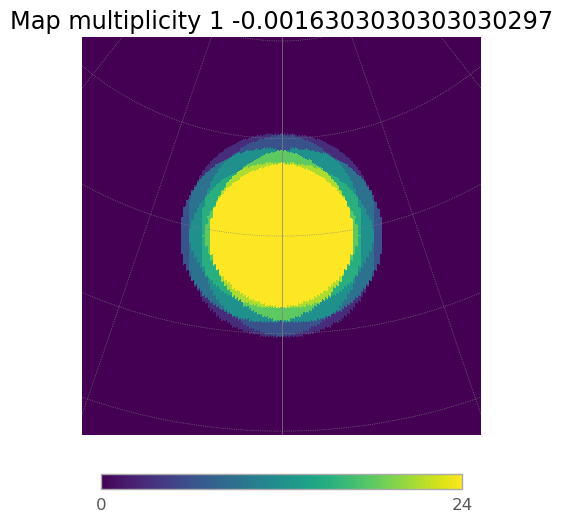

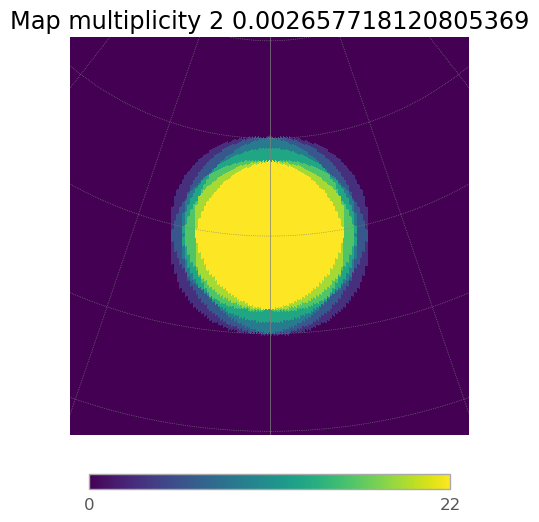

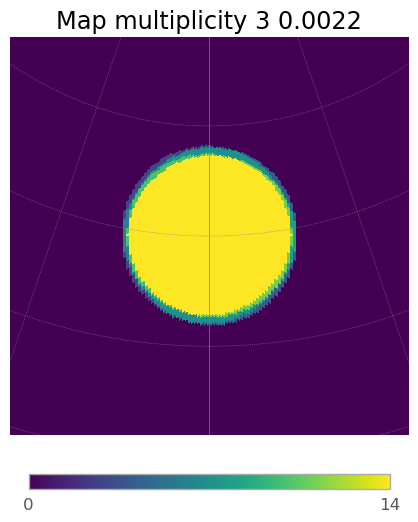

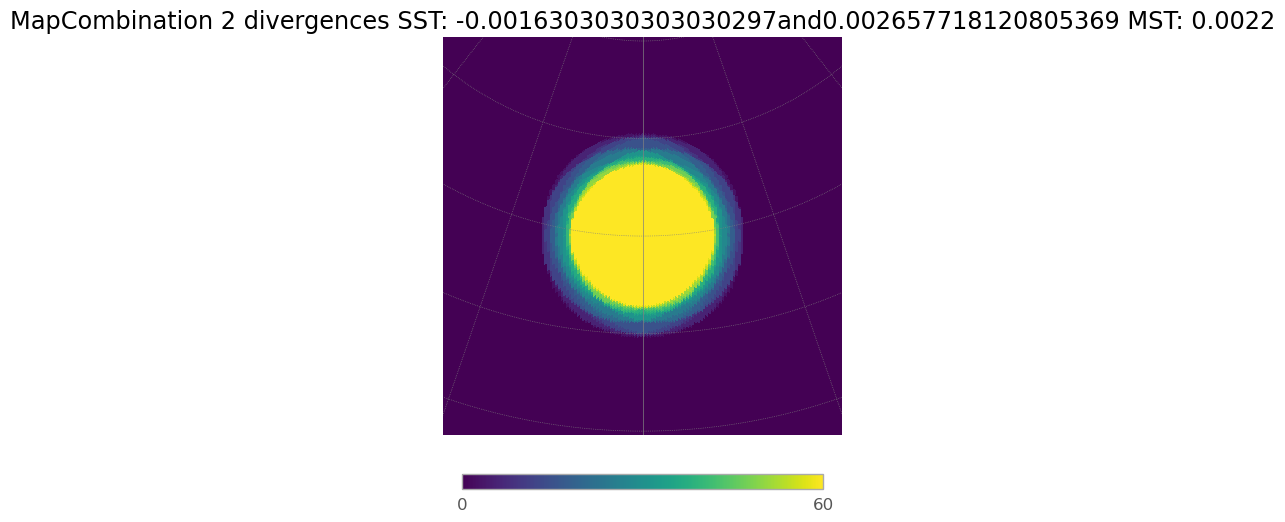

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  7.14it/s]
7it [00:00,  7.21it/s]
4it [00:00,  6.79it/s]
6it [00:00,  6.77it/s]


10.38234806580255


7it [00:00,  7.13it/s]
4it [00:00,  6.99it/s]


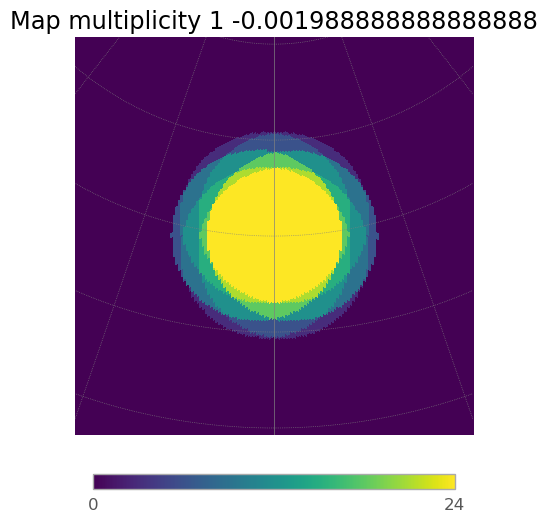

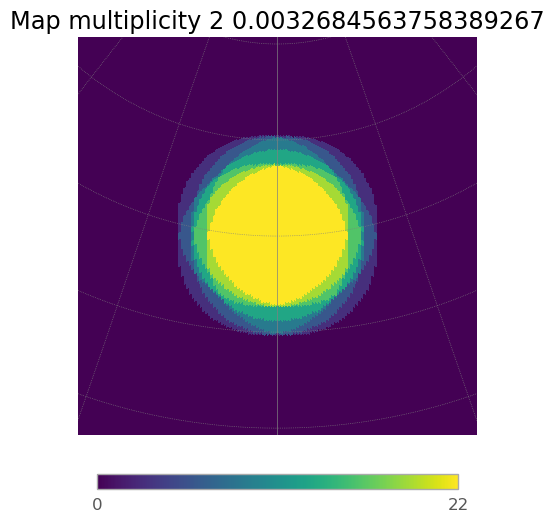

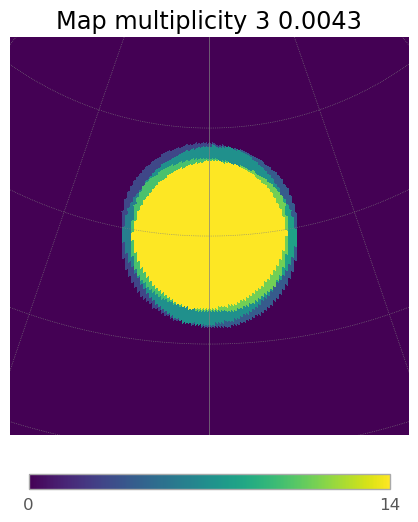

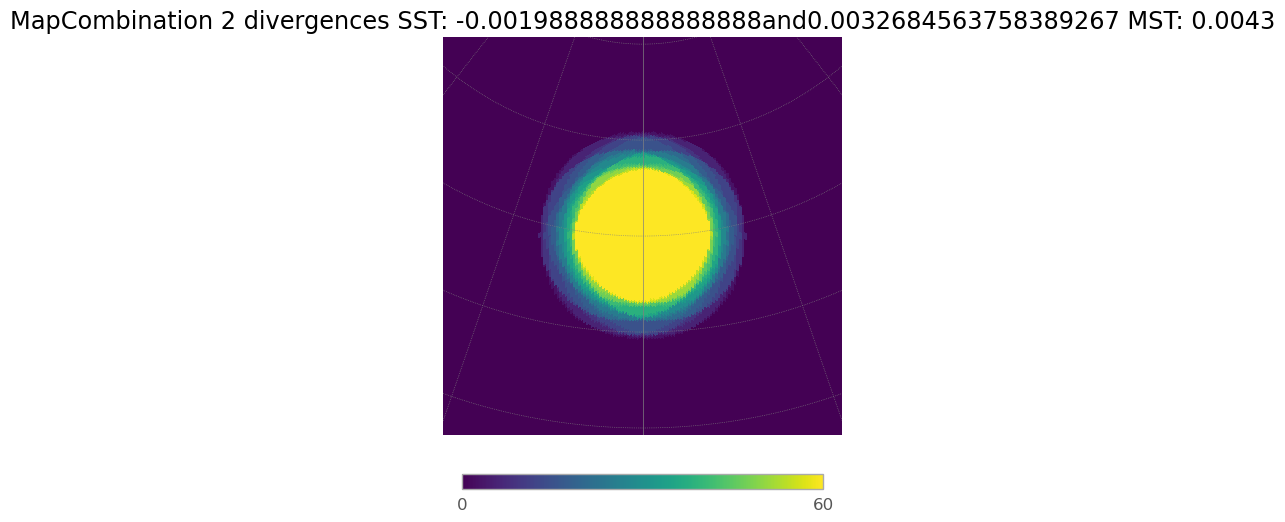

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  7.00it/s]
7it [00:01,  6.86it/s]
4it [00:00,  7.06it/s]
6it [00:00,  6.91it/s]


10.681907090507448


7it [00:00,  7.12it/s]
4it [00:00,  6.92it/s]


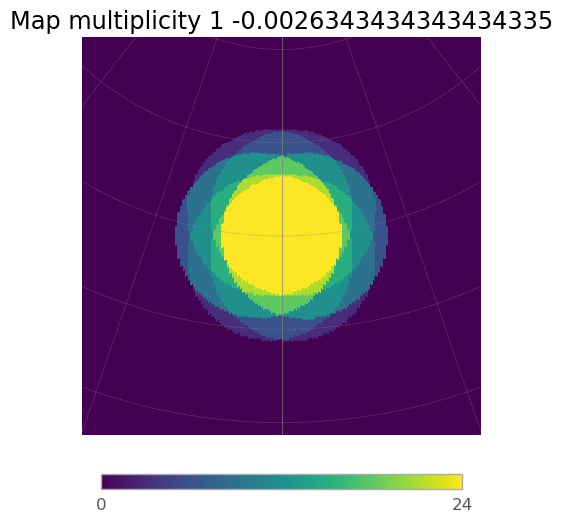

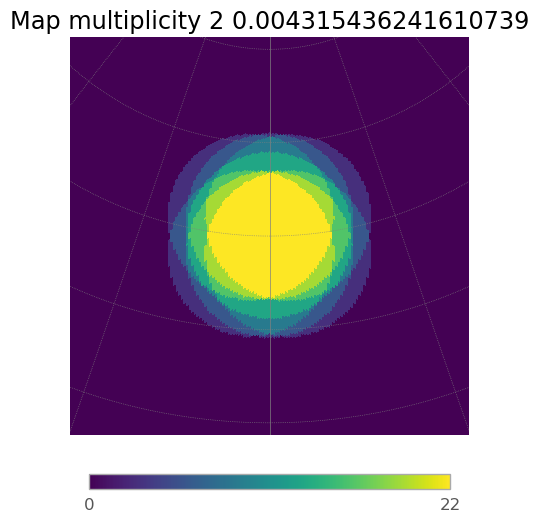

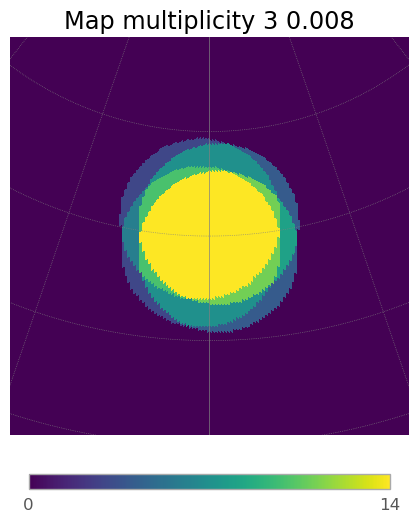

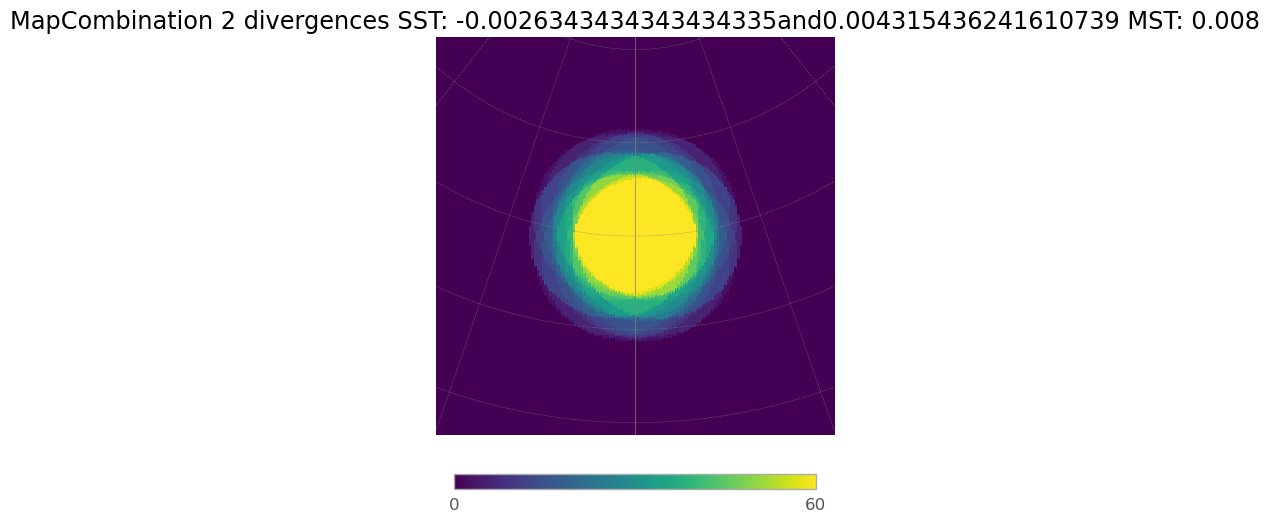

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  7.13it/s]
7it [00:00,  7.06it/s]
4it [00:00,  6.87it/s]
6it [00:00,  6.68it/s]


10.976231771331125


7it [00:00,  7.09it/s]
4it [00:00,  7.34it/s]


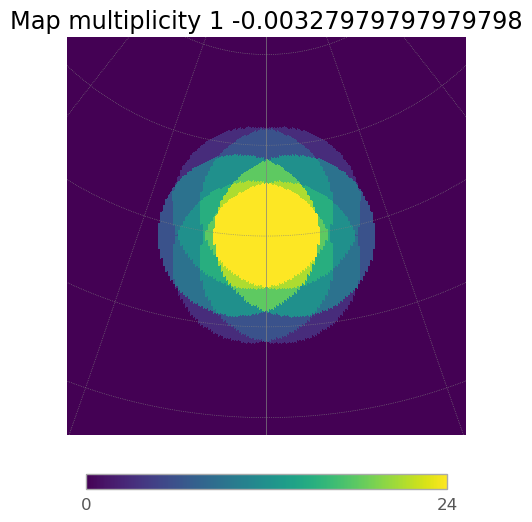

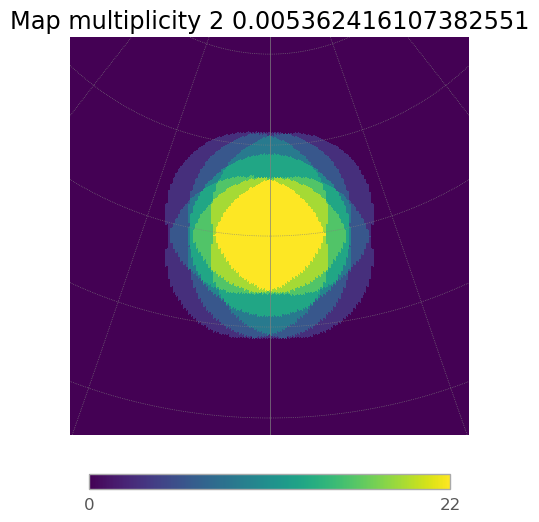

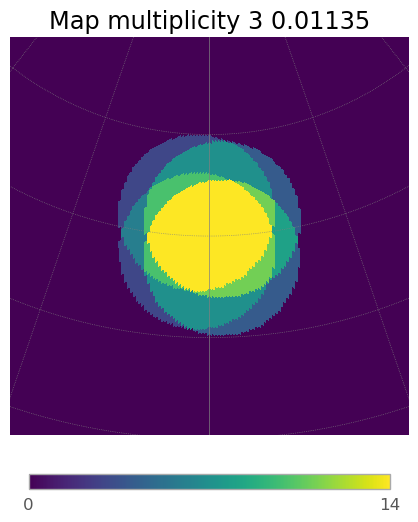

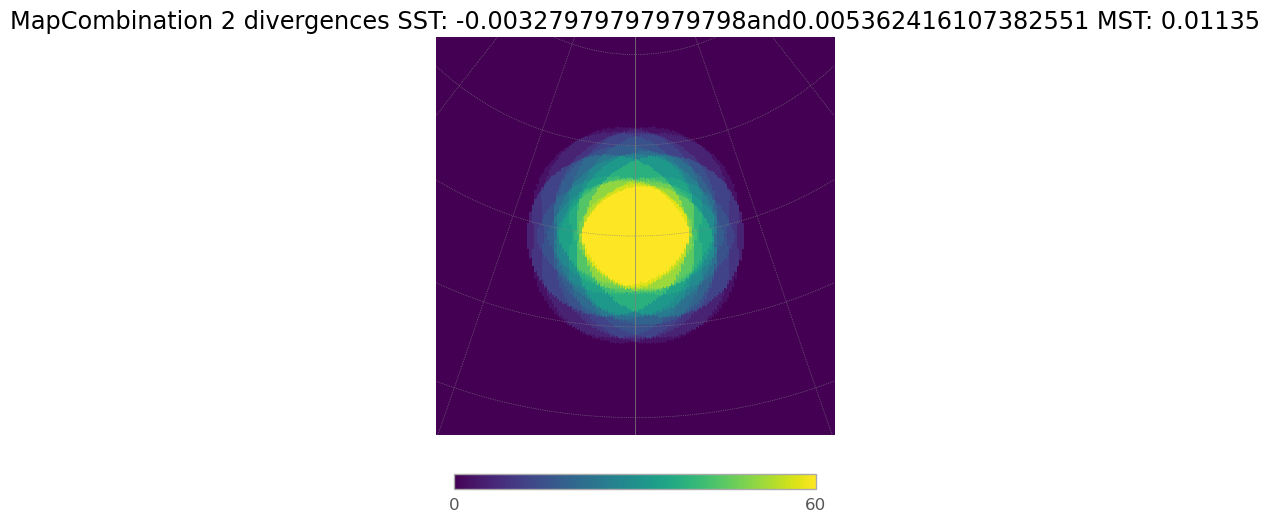

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  7.01it/s]
7it [00:00,  7.11it/s]
4it [00:00,  7.09it/s]
6it [00:00,  6.94it/s]


11.267724963705167


7it [00:00,  7.16it/s]
4it [00:00,  6.97it/s]


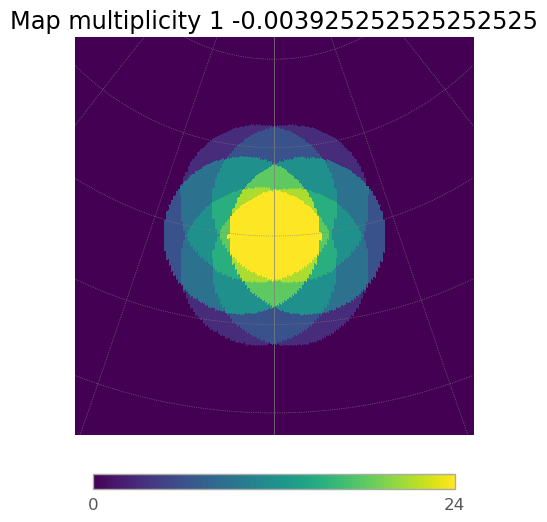

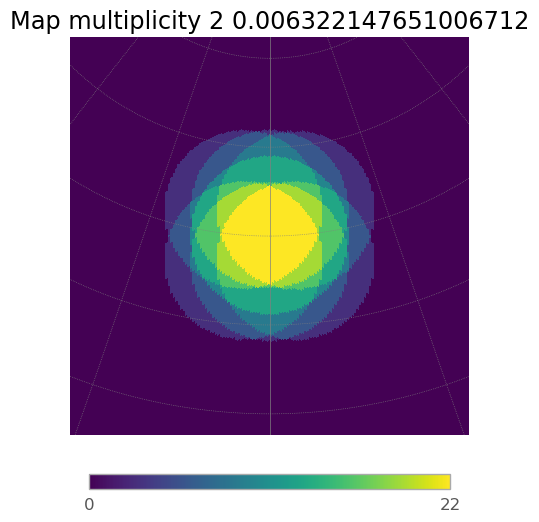

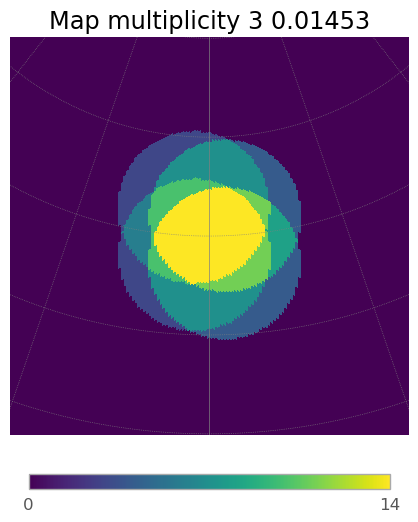

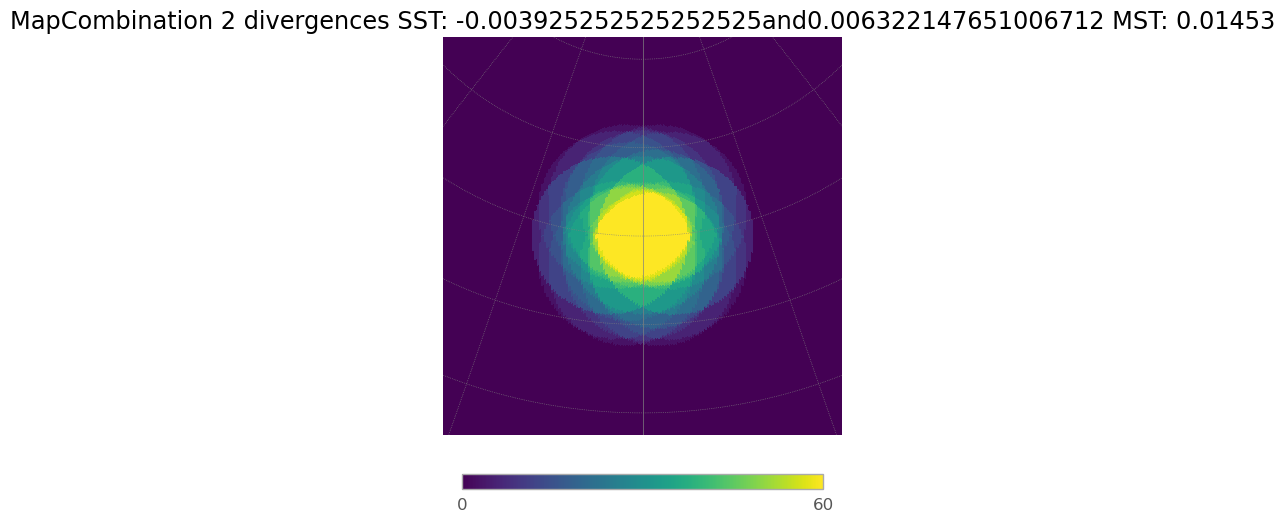

In [71]:

div_MST=[0.0022,0.0043, 0.008, 0.01135, 0.01453 ]
div_SST=divergence_list
conv_SST=convergence_list
for i in range(5):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    SST_config_conv.multiplicity_plot_3_config(array_2=SST_config_div,array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3= number_of_telescopes_subarray_1)





## UP TO 0.03

In [72]:
div_MST=[0.0022,0.0043, 0.008, 0.01135, 0.01453, 0.01753, 0.02053, 0.02353, 0.02653, 0.02953]

In [ ]:
divergence_list=[]
div_SST=np.linspace(0.001,0.02222, 200)
for divergence in div_MST:
    for divergence_SST in div_SST:
        print(f" the div{divergence_SST}")
        config_MST.divergent_pointing(div=divergence, az=0, alt=70)
        hFoV_to_stop=config_MST.hFoV(m_cut=13, subarray_mult=number_of_telescopes_subarray_1 )[0]
        SST_config_div.divergent_pointing(div=divergence_SST, az=0, alt=70)
        print(f" the stop{round(hFoV_to_stop)}")
        hFoV_div=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        print(f" the div h FoV {round(hFoV_div)}")
        if round(hFoV_div) == round(hFoV_to_stop):
            divergence_SST=round(divergence_SST, 6)
            divergence_list.append(divergence_SST)
            print(f"stop, the {divergence_SST}")
            break 

 the div0.001


4it [00:00,  4.72it/s]


 the stop42


7it [00:01,  4.19it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:01,  3.72it/s]


 the stop42


7it [00:01,  4.20it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  4.40it/s]


 the stop42


7it [00:01,  4.66it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:01,  3.22it/s]


 the stop42


7it [00:01,  4.44it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  4.31it/s]


 the stop42


7it [00:01,  4.16it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  4.09it/s]


 the stop42


7it [00:01,  4.23it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  4.02it/s]


 the stop42


7it [00:01,  4.21it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  5.10it/s]


 the stop42


7it [00:01,  4.61it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  4.77it/s]


 the stop42


7it [00:01,  4.65it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  4.92it/s]


 the stop42


7it [00:01,  5.69it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  6.43it/s]


 the stop42


7it [00:01,  6.27it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  6.44it/s]


 the stop42


7it [00:01,  6.49it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  6.66it/s]


 the stop42


7it [00:01,  6.32it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  6.18it/s]


 the stop42


7it [00:01,  6.41it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  6.58it/s]


 the stop42


7it [00:01,  6.33it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  6.55it/s]


 the stop42


7it [00:01,  6.47it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  6.49it/s]


 the stop42


7it [00:01,  6.23it/s]


 the div h FoV 42
stop, the 0.002706
 the div0.001


4it [00:00,  6.35it/s]


 the stop38


7it [00:01,  6.40it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  6.44it/s]


 the stop38


7it [00:01,  6.26it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  6.26it/s]


 the stop38


7it [00:01,  6.25it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  6.36it/s]


 the stop38


7it [00:01,  6.37it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  6.21it/s]


 the stop38


7it [00:01,  6.17it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  6.21it/s]


 the stop38


7it [00:01,  6.24it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  5.75it/s]


 the stop38


7it [00:01,  6.00it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  5.41it/s]


 the stop38


7it [00:01,  6.77it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.07it/s]


 the stop38


7it [00:01,  6.95it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  7.01it/s]


 the stop38


7it [00:00,  7.05it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  6.96it/s]


 the stop38


7it [00:00,  7.11it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  6.81it/s]


 the stop38


7it [00:00,  7.10it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  7.08it/s]


 the stop38


7it [00:01,  6.74it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.28it/s]


 the stop38


7it [00:00,  7.42it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  6.99it/s]


 the stop38


7it [00:00,  7.28it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  6.72it/s]


 the stop38


7it [00:01,  6.72it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  6.46it/s]


 the stop38


7it [00:01,  5.92it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  6.04it/s]


 the stop38


7it [00:01,  6.08it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  6.49it/s]


 the stop38


7it [00:01,  6.21it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  6.09it/s]


 the stop38


7it [00:01,  5.98it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  5.96it/s]


 the stop38


7it [00:01,  6.17it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  6.49it/s]


 the stop38


7it [00:01,  6.11it/s]


 the div h FoV 38
stop, the 0.003239
 the div0.001


4it [00:00,  5.83it/s]


 the stop31


7it [00:01,  6.03it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  6.01it/s]


 the stop31


7it [00:01,  6.07it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  6.21it/s]


 the stop31


7it [00:01,  5.92it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  6.30it/s]


 the stop31


7it [00:01,  6.19it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  5.83it/s]


 the stop31


7it [00:01,  6.10it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  6.88it/s]


 the stop31


7it [00:01,  6.98it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  6.95it/s]


 the stop31


7it [00:01,  6.67it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  7.01it/s]


 the stop31


7it [00:00,  7.18it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.04it/s]


 the stop31


7it [00:00,  7.03it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  6.82it/s]


 the stop31


7it [00:00,  7.04it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  6.96it/s]


 the stop31


7it [00:01,  6.91it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.18it/s]


 the stop31


7it [00:00,  7.22it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  6.81it/s]


 the stop31


7it [00:00,  7.06it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.15it/s]


 the stop31


7it [00:00,  7.16it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  6.83it/s]


 the stop31


7it [00:00,  7.06it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.11it/s]


 the stop31


7it [00:00,  7.23it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  6.37it/s]


 the stop31


7it [00:01,  6.91it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  7.13it/s]


 the stop31


7it [00:00,  7.09it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  7.12it/s]


 the stop31


7it [00:00,  7.20it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  7.30it/s]


 the stop31


7it [00:00,  7.21it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  7.25it/s]


 the stop31


7it [00:01,  6.95it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  7.03it/s]


 the stop31


7it [00:01,  6.92it/s]


 the div h FoV 38
 the div0.003345929648241206


4it [00:00,  7.34it/s]


 the stop31


7it [00:00,  7.30it/s]


 the div h FoV 38
 the div0.0034525628140703517


4it [00:00,  7.29it/s]


 the stop31


7it [00:00,  7.20it/s]


 the div h FoV 37
 the div0.0035591959798994973


4it [00:00,  7.40it/s]


 the stop31


7it [00:01,  6.99it/s]


 the div h FoV 36
 the div0.003665829145728643


4it [00:00,  6.99it/s]


 the stop31


7it [00:01,  5.70it/s]


 the div h FoV 35
 the div0.003772462311557789


4it [00:00,  7.32it/s]


 the stop31


7it [00:01,  6.99it/s]


 the div h FoV 35
 the div0.0038790954773869346


4it [00:00,  7.21it/s]


 the stop31


7it [00:01,  6.27it/s]


 the div h FoV 34
 the div0.00398572864321608


4it [00:00,  6.93it/s]


 the stop31


7it [00:01,  6.60it/s]


 the div h FoV 33
 the div0.004092361809045226


4it [00:00,  6.95it/s]


 the stop31


7it [00:01,  6.96it/s]


 the div h FoV 33
 the div0.0041989949748743715


4it [00:00,  6.97it/s]


 the stop31


7it [00:01,  6.99it/s]


 the div h FoV 32
 the div0.004305628140703517


4it [00:00,  7.13it/s]


 the stop31


7it [00:00,  7.21it/s]


 the div h FoV 31
stop, the 0.004306
 the div0.001


4it [00:00,  6.94it/s]


 the stop25


7it [00:01,  6.86it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  7.08it/s]


 the stop25


7it [00:01,  6.98it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  7.15it/s]


 the stop25


7it [00:01,  6.77it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  6.89it/s]


 the stop25


7it [00:01,  6.46it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  6.78it/s]


 the stop25


7it [00:00,  7.01it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.02it/s]


 the stop25


7it [00:01,  6.77it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  6.72it/s]


 the stop25


7it [00:01,  6.41it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  6.97it/s]


 the stop25


7it [00:00,  7.03it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.14it/s]


 the stop25


7it [00:00,  7.38it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  6.83it/s]


 the stop25


7it [00:00,  7.20it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  7.24it/s]


 the stop25


7it [00:00,  7.46it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.07it/s]


 the stop25


7it [00:00,  7.02it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  6.93it/s]


 the stop25


7it [00:00,  7.01it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  6.97it/s]


 the stop25


7it [00:00,  7.42it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.24it/s]


 the stop25


7it [00:00,  7.08it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.25it/s]


 the stop25


7it [00:00,  7.19it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  7.20it/s]


 the stop25


7it [00:01,  6.81it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  7.10it/s]


 the stop25


7it [00:01,  6.97it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  7.11it/s]


 the stop25


7it [00:00,  7.27it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  7.03it/s]


 the stop25


7it [00:01,  6.86it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  6.98it/s]


 the stop25


7it [00:01,  6.95it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  6.68it/s]


 the stop25


7it [00:00,  7.20it/s]


 the div h FoV 38
 the div0.003345929648241206


4it [00:00,  7.16it/s]


 the stop25


7it [00:00,  7.22it/s]


 the div h FoV 38
 the div0.0034525628140703517


4it [00:00,  7.11it/s]


 the stop25


7it [00:00,  7.22it/s]


 the div h FoV 37
 the div0.0035591959798994973


4it [00:00,  7.18it/s]


 the stop25


7it [00:00,  7.01it/s]


 the div h FoV 36
 the div0.003665829145728643


4it [00:00,  7.07it/s]


 the stop25


7it [00:00,  7.18it/s]


 the div h FoV 35
 the div0.003772462311557789


4it [00:00,  7.26it/s]


 the stop25


7it [00:00,  7.30it/s]


 the div h FoV 35
 the div0.0038790954773869346


4it [00:00,  7.33it/s]


 the stop25


7it [00:00,  7.22it/s]


 the div h FoV 34
 the div0.00398572864321608


4it [00:00,  7.26it/s]


 the stop25


7it [00:00,  7.26it/s]


 the div h FoV 33
 the div0.004092361809045226


4it [00:00,  7.02it/s]


 the stop25


7it [00:00,  7.14it/s]


 the div h FoV 33
 the div0.0041989949748743715


4it [00:00,  6.92it/s]


 the stop25


7it [00:00,  7.09it/s]


 the div h FoV 32
 the div0.004305628140703517


4it [00:00,  7.02it/s]


 the stop25


7it [00:01,  6.88it/s]


 the div h FoV 31
 the div0.004412261306532663


4it [00:00,  7.07it/s]


 the stop25


7it [00:01,  6.96it/s]


 the div h FoV 31
 the div0.004518894472361808


4it [00:00,  7.31it/s]


 the stop25


7it [00:00,  7.14it/s]


 the div h FoV 30
 the div0.004625527638190954


4it [00:00,  7.25it/s]


 the stop25


7it [00:00,  7.06it/s]


 the div h FoV 30
 the div0.0047321608040201005


4it [00:00,  7.18it/s]


 the stop25


7it [00:01,  6.92it/s]


 the div h FoV 29
 the div0.004838793969849246


4it [00:00,  7.24it/s]


 the stop25


7it [00:01,  6.64it/s]


 the div h FoV 28
 the div0.004945427135678392


4it [00:00,  7.00it/s]


 the stop25


7it [00:00,  7.15it/s]


 the div h FoV 28
 the div0.005052060301507537


4it [00:00,  7.38it/s]


 the stop25


7it [00:00,  7.08it/s]


 the div h FoV 27
 the div0.005158693467336683


4it [00:00,  6.89it/s]


 the stop25


7it [00:00,  7.20it/s]


 the div h FoV 26
 the div0.005265326633165829


4it [00:00,  7.39it/s]


 the stop25


7it [00:01,  6.98it/s]


 the div h FoV 26
 the div0.005371959798994974


4it [00:00,  7.05it/s]


 the stop25


7it [00:00,  7.10it/s]


 the div h FoV 25
stop, the 0.005372
 the div0.001


4it [00:00,  7.12it/s]


 the stop20


7it [00:00,  7.34it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  7.08it/s]


 the stop20


7it [00:00,  7.36it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  7.22it/s]


 the stop20


7it [00:00,  7.22it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  7.17it/s]


 the stop20


7it [00:00,  7.37it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  7.17it/s]


 the stop20


7it [00:01,  6.50it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.09it/s]


 the stop20


7it [00:00,  7.22it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  6.73it/s]


 the stop20


7it [00:00,  7.13it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  7.06it/s]


 the stop20


7it [00:00,  7.18it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.18it/s]


 the stop20


7it [00:00,  7.42it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  7.37it/s]


 the stop20


7it [00:00,  7.32it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  7.10it/s]


 the stop20


7it [00:01,  6.93it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  6.79it/s]


 the stop20


7it [00:01,  6.99it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  6.85it/s]


 the stop20


7it [00:00,  7.13it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.30it/s]


 the stop20


7it [00:00,  7.29it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.22it/s]


 the stop20


7it [00:00,  7.08it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.11it/s]


 the stop20


1it [00:00,  7.41it/s]

In [ ]:
conv=np.linspace(-0.0083,-0.0012, 100)
convergence_list=[]
for divergence in divergence_list:
    for convergence in conv:
        SST_config_div.divergent_pointing(div=divergence, az=0, alt=70)
        hFoV_to_stop=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        SST_config_conv.divergent_pointing(div=convergence, az=0, alt=70)
        hFoV_conv=SST_config_conv.hFoV(subarray_mult=number_of_telescopes_config_SST_first_half,m_cut=23)[0]
        if hFoV_conv > hFoV_to_stop:
            convergence=round(convergence,5)
            convergence_list.append(convergence)
            print(f"stop, the {convergence}")
            break 

In [ ]:
div_SST=divergence_list
conv_SST=convergence_list
for i in range(10):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    SST_config_conv.multiplicity_plot_3_config(array_2=SST_config_div,array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3= number_of_telescopes_subarray_1)



In [ ]:
SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)

In [ ]:
div_SST=divergence_list
conv_SST=convergence_list
m_ave_combine=[]
hFoV_combine=[]
for i in range(10):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    hFoV_combine.append(SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)[0])
    m_ave_combine.append(SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)[1])





In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6)) 
# Plot Full Array
# Full Array with m_cut = 3
#l1=axes[0].plot(chosen_divergences, FoV_full_array, label='FoV', marker='o', color='darkgreen')
#ax2 = axes[0].twinx()
#l2=ax2.plot(chosen_divergences, multiplicity_full_array, label='Multiplicities',marker='*', color='limegreen')
#axes[0].set_title('Full Array m_cut 3')
#axes[0].set_xlabel('Divergence')
#axes[0].set_ylabel('Field of view (m > 3) [deg$^2$]')
#ax2.set_ylabel('Multiplicities (m>3)')
#axeslegend = l1+l2
#axes[0].legend(axeslegend, [l.get_label() for l in axeslegend])



#Plot the ones for subarray 1
l1=axes[1].plot(divergence_list,hFoV_combine, label='FoV',marker='o', color='darkgreen')
ax5=axes[1].twinx()
l2=ax5.plot(divergence_list, m_ave_combine, label='Multiplicity', marker='*', color='limegreen')
axes[1].set_title('Configurations Combined')
axes[1].set_xlabel('Divergence')
axes[1].set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[1].legend(axeslegend, [l.get_label() for l in axeslegend])
#Plot the ones for subarray 2

# Adjust layout
plt.tight_layout()
# Subarray 4
# Adjust layout
plt.show()

In [ ]:
print(SST_config_conv.barycenter)

In [ ]:
print(SST_config_div.barycenter)

In [ ]:
print(full_array_config_SST.barycenter)

In [ ]:
for i in range(10):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    SST_config_conv.combination_bar_graph_av_mult_MST_and_SST(array_2=SST_config_div, array_3=config_MST,subarray_mult=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)
    

In [ ]:
SST_config_div